[WeatherBench 2](https://weatherbench2.readthedocs.io/en/latest/)

**WeatherBench 2** is a framework for evaluating and comparing data-driven and traditional numerical weather forecasting models.

# **I-GOOGLE ACCOUNT AUTHENTIFICATION**

In [ ]:
from google.colab import auth
auth.authenticate_user()


# **II-IMPORT THE REQUIREMENTS LIBRARIES**

In [ ]:
# !pip install cupy
# import cupy as cp

In [ ]:
! pip install -q -U zarr xarray gcsfs
import xarray as xr
import gcsfs
import zarr
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:

# define the neuralgcm path data
ngcm_path = 'gs://neuralgcm/amip_runs/v1_precip_stochastic_2_8_deg/2001-to-2021_128x64_gauss_37-level_stride3h.zarr'
#load the data
# ngcm_data = xr.open_zarr(ngcm_path,chunks={"time":100})
ngcm_data = xr.open_zarr(ngcm_path)

<ipython-input-3-cd22bc7a61c8>:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ngcm_data = xr.open_zarr(ngcm_path)


In [ ]:
#the size of the neural gcm data
ngcm_data.nbytes/1e9

1628.740724872

# **Data Understanding**

In [ ]:
ngcm_data.info()

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 58408 ;
	surface = 1 ;
	longitude = 128 ;
	latitude = 64 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_o

In [ ]:
ngcm_data.precipitation_cumulative_mean


<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 128,
                                                   latitude: 64)> Size: 71GB
dask.array<open_dataset-precipitation_cumulative_mean, shape=(37, 58408, 1, 128, 64), dtype=float32, chunksize=(1, 8, 1, 128, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

##❗ **Questions:**



*   I had a question about what the base date is for adding the prediction_timedelta, and to resolve it, by checking the number of values in prediction_timedelta and the values it contains, I concluded that the base time is the minimum of the time coordinate.



In [ ]:
#the min and the max values of time in the global neural GCM
print(f"the min date is :",ngcm_data.time.min().values)
print(f"the max date is :",ngcm_data.time.max().values)

the min date is : 2001-01-01T00:00:00.000000000
the max date is : 2001-12-27T00:00:00.000000000


In [ ]:
#the prediction time
ngcm_data.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

In [ ]:
#Calculate the exact range of days covered by NeuralGCM.
import pandas as pd

base_date = pd.Timestamp(ngcm_data.time.min().values)
offset = pd.Timedelta(days=7300, hours=21)
final_date = base_date + offset

print(final_date)


2020-12-27 21:00:00


In [ ]:
#Calculate the exact range of days covered by NeuralGCM.
import pandas as pd

base_date = pd.Timestamp(ngcm_data.time.max().values)
offset = pd.Timedelta(days=7300, hours=21)
final_date = base_date + offset

print(final_date)


2021-12-22 21:00:00



### 📊 **Dataset Variable Descriptions**


[source](https://github.com/neuralgcm/neuralgcm/blob/main/docs/data_preparation.ipynb)

NeuralGCM models take and produce data on defined on ERA5's 37 pressure levels, including the following variables, provided in SI units and on the NeuralGCM model's native grid:

    Inputs/outputs (on pressure levels): u_component_of_wind, v_component_of_wind, geopotential, temperature, specific_humidity, specific_cloud_ice_water_content, specific_cloud_liquid_water_content.
    Forcings (surface level only): sea_surface_temperature, sea_ice_cover

This dataset contains atmospheric and surface-level variables structured along multiple dimensions. Below is an explanation of each variable:

---

#### 📅 **Temporal Dimensions**

* **`time(time)`** *(datetime64\[ns])*:
  Represents the base timestamps of the forecasts. Each entry corresponds to a specific initialization time.

* **`prediction_timedelta(prediction_timedelta)`** *(timedelta64\[ns])*:
  Specifies the lead times (time offsets) from the base `time`.

---

#### 🌍 **Spatial Dimensions**

* **`longitude(longitude)`** *(float64)*:
  Array of longitudes in degrees (typically 0° to 360° or -180° to 180° depending on the convention used).

* **`latitude(latitude)`** *(float64)*:
  Array of latitudes in degrees (typically from -90° to 90°).

* **`level(level)`** *(int64)*:
  Pressure levels in hPa for variables defined in the atmosphere . This dimension is used for 3D atmospheric fields.

* **`surface(surface)`** *(int64)*:
  A scalar or categorical indicator to mark variables defined at the Earth's surface.

---

#### 🌦️ **Forecast Variables**

* **`evaporation(time, prediction_timedelta, surface, longitude, latitude)`** *(float32)*:
  Total evaporation at the surface (kg/m² or mm equivalent), forecasted over time.

* **`geopotential(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Geopotential height at various pressure levels (m²/s²), often used to represent height contours in meteorology.

* **`precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude)`** *(float32)*:
  Cumulative mean precipitation (total rainfall) at the surface.

* **`specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The concentration of ice water in clouds at different atmospheric levels.

* **`specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The concentration of liquid water in clouds at different atmospheric levels.

* **`specific_humidity(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The amount of water vapor per unit mass of air at given pressure levels.

* **`temperature(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Air temperature at various atmospheric pressure levels (in Kelvin).

* **`u_component_of_wind(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Zonal (east-west) component of the wind at different levels.

* **`v_component_of_wind(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Meridional (north-south) component of the wind at different levels.

---
### ⚡**Analysis**

* we can conclude that the data of neural gcm is between **2001-01-01 00:00:00** and **2020-12-27 21:00:00**


| Variable Name                               | SI Unit             | Description                                                                                                                |
| ------------------------------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **evaporation**                             | **kg/m²** *(or mm)* | Total amount of water evaporated per unit area. In meteorology, **1 kg/m² = 1 mm** of water.                               |
| **geopotential**                            | **m²/s²**           | Gravitational potential energy per unit mass. Often divided by **g = 9.81 m/s²** to get **geopotential height in meters**. |
| **precipitation\_cumulative\_mean**         | **kg/m²** *(or mm)* | Cumulative mean surface precipitation. As with evaporation, **1 kg/m² = 1 mm** of rainfall.                                |
| **specific\_cloud\_ice\_water\_content**    | **kg/kg**           | Mass of ice water in clouds per unit mass of moist air.                                                                    |
| **specific\_cloud\_liquid\_water\_content** | **kg/kg**           | Mass of liquid water in clouds per unit mass of moist air.                                                                 |
| **specific\_humidity**                      | **kg/kg**           | Mass of water vapor per unit mass of moist air (dimensionless but expressed in kg/kg).                                     |
| **temperature**                             | **K** *(Kelvin)*    | Air temperature at different pressure levels.                                                                              |
| **u\_component\_of\_wind**                  | **m/s**             | Zonal (east-west) wind speed. Positive = eastward.                                                                         |
| **v\_component\_of\_wind**                  | **m/s**             | Meridional (north-south) wind speed. Positive = northward.                                                                 |


# **neuralGCM data for our domain**

In [ ]:
#select Horn Africa data
ngcm_data_africa = ngcm_data.sel(latitude=slice(-20,30),longitude=slice(15,60))


In [ ]:
ngcm_data_africa

<xarray.Dataset> Size: 57GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 58408,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 467kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.3 MB/s eta 0:00:00


Longitude shape: (16,)
Latitude shape: (18,)
Data shape: (16, 18)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


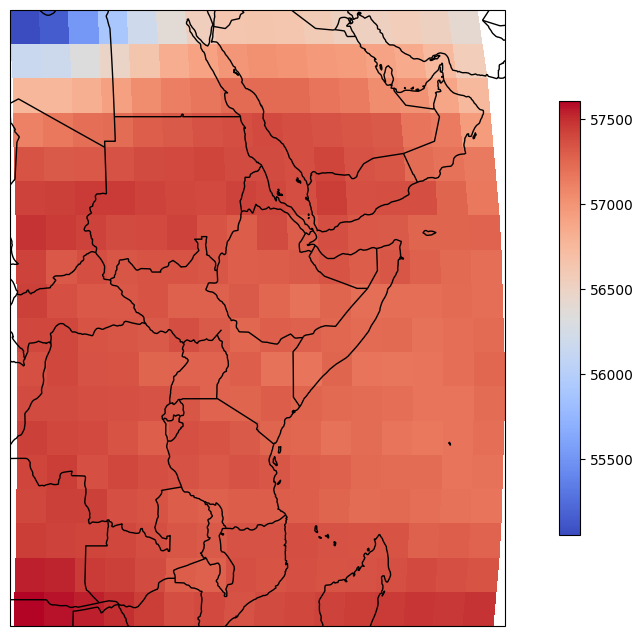

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = ngcm_data_africa.longitude.values
lats = ngcm_data_africa.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# Compute the mean along the 'prediction_timedelta' dimension
geopotential_mean = ngcm_data_africa.geopotential.isel({'time':0,'level':0,'prediction_timedelta':ngcm_data_africa.prediction_timedelta[0]}).values
print(f"Data shape: {geopotential_mean.shape}")
c = plt.pcolormesh(lons, lats, geopotential_mean.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)


In [ ]:
# Identify precipitation variable name (commonly 'tp' or 'precip')
precip_name = [var for var in ngcm_data_africa.data_vars if 'precip' in var or 'tp' in var][0]
precip = ngcm_data_africa[precip_name]
precip

<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 16,
                                                   latitude: 18)> Size: 2GB
dask.array<getitem, shape=(37, 58408, 1, 16, 18), dtype=float32, chunksize=(1, 8, 1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

In [ ]:
#the size of the horn africa data in GO
ngcm_data_africa.nbytes/1e9

57.26086748

In [ ]:
#the prediction time
ngcm_data_africa.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

# we can now selected the 6h time delta

In [ ]:
#select the climate timeset where prediction_timedelta is a multiple of 6h

# Convert prediction_timedelta to a pandas Series for easier manipulation
prediction_timedelta_series = pd.Series(ngcm_data_africa.prediction_timedelta.values)

# Select values where prediction_timedelta is a multiple of 6 hours (in seconds)
selected_indices = prediction_timedelta_series[prediction_timedelta_series % pd.Timedelta(hours=6) == pd.Timedelta(0)].index

# Use the selected indices to filter the entire dataset
selected_data = ngcm_data_africa.isel(prediction_timedelta=selected_indices)

selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
selected_data.nbytes/1e9

28.63043404

In [ ]:
print(selected_data.info())

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 29204 ;
	surface = 1 ;
	longitude = 16 ;
	latitude = 18 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_of

# correlation plot

#1-select the first level

In [ ]:
# Sélect one level and one surface(surface=1, level=0)
ds_subset_1 = selected_data.sel(level=selected_data.level[0],time=selected_data.time[-1])
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

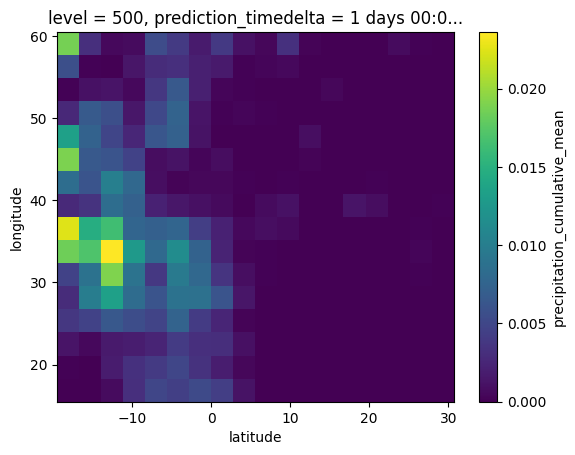

In [ ]:
ds_subset_1.precipitation_cumulative_mean.sel(prediction_timedelta=ds_subset_1.prediction_timedelta[4]).plot()

In [ ]:
# ds_subset_1= ds_subset_1['precipitation_cumulative_mean'].diff(dim='prediction_timedelta')

In [ ]:
# ds_subset_1

In [ ]:
ds_subset_1 = ds_subset_1.assign(precipitation_cum_6h=ds_subset_1['precipitation_cumulative_mean'].diff(dim='prediction_timedelta'))

In [ ]:
ds_subset_1

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

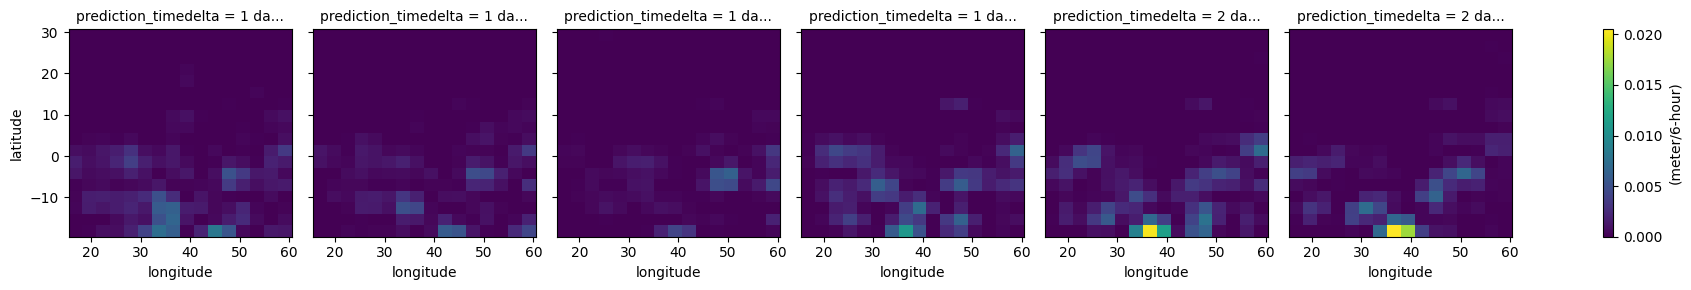

In [ ]:
ds_subset_1.precipitation_cumulative_mean.isel(
   surface=0, prediction_timedelta=slice(3, 10)
).diff('prediction_timedelta').plot(
    x='longitude',
    col='prediction_timedelta',
    cbar_kwargs={'label': '(meter/6-hour)'},
)  # In m per 6 hours


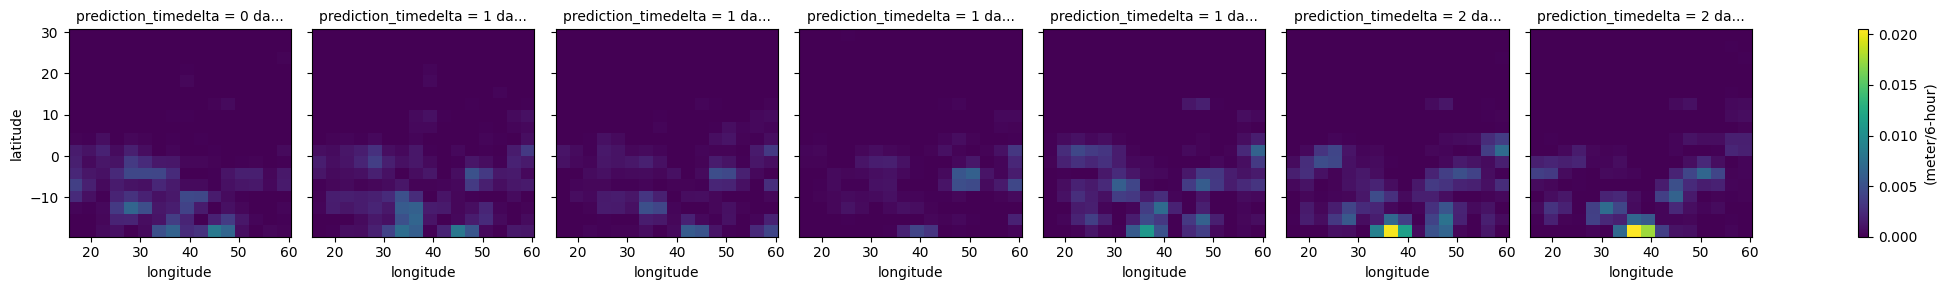

In [ ]:
ds_subset_1.precipitation_cum_6h.isel(
   surface=0, prediction_timedelta=slice(3, 10)
).plot(
    x='longitude',
    col='prediction_timedelta',
    cbar_kwargs={'label': '(meter/6-hour)'},
)  # In m per 6 hours


In [ ]:
# Récupère toutes les variables sauf les coordonnées
vars_to_test = [v for v in ds_subset_1.data_vars if v not in ['longitude', 'latitude', 'precipitation_cum_6h']]
vars_to_test

['evaporation',
 'geopotential',
 'precipitation_cumulative_mean',
 'specific_cloud_ice_water_content',
 'specific_cloud_liquid_water_content',
 'specific_humidity',
 'temperature',
 'u_component_of_wind',
 'v_component_of_wind']

In [ ]:
correlations = {}
for var in vars_to_test:
    corr = xr.corr(ds_subset_1['precipitation_cum_6h'], ds_subset_1[var], dim='prediction_timedelta')
    correlations[var] = corr


In [ ]:
ds_subset_1

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
correlations_ds = xr.Dataset(correlations)
correlations_ds

<xarray.Dataset> Size: 11kB
Dimensions:                              (latitude: 18, longitude: 16,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
# prompt: je veux creer un xarray qui contient les correlations la parce que apres je vais afficher sur un cartopy

# Convert the dictionary of correlations to a Dataset
correlations_ds = xr.Dataset(correlations)

# Add latitude and longitude as coordinates to the Dataset
correlations_ds = correlations_ds.assign_coords(latitude=ds_subset_1.latitude, longitude=ds_subset_1.longitude)


#Now you have an xarray Dataset 'correlations_ds' containing the correlations.
#You can access individual correlations like this:
# correlations_ds['temperature'].plot() # Example: plot temperature correlation


# Example of how to plot on cartopy:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Choose the variable you want to plot from the correlations_ds
variable_to_plot = 'temperature'  # Example: temperature

correlations_ds[variable_to_plot].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Choose a suitable colormap
    cbar_kwargs={'label': f'Correlation with precipitation_cum_6h'},
)


ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_title(f'Correlation of {variable_to_plot} with precipitation_cum_6h')

plt.show()

In [ ]:
# from typing import ChainMap
# for i in vars_to_test:
#   print(f"Correlation between {i} and precipitation:")
#   correlations[i].plot(cmap='coolwarm',vmin=-1,vmax=1,figsize=(10,5),robust=True,cbar_kwargs={'label':'Correlation map'})

In [ ]:
import seaborn as sns
import pandas as pd

corr_df = pd.DataFrame({
    "Variable": list(correlations.keys()),
    "Correlation": [c.mean().item() for c in correlations.values()]
})
corr_df = corr_df.sort_values("Correlation", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x="Correlation", y="Variable", palette="viridis")
plt.title("Spatial Correlation vs Precipitation")
plt.grid(True)
plt.tight_layout()
plt.show()


# correlation betweeen mean precipitation and other mean variable (per month) over year(2018) for the time

In [ ]:
#  Sélect one level and one surface(surface=1, level=0)
ds_subset_1 = selected_data.sel(level=selected_data.level[0],time=selected_data.time[-1])
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
ds_subset_1 = ds_subset_1.sel(surface=1)
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (prediction_timedelta: 29204,
                                          longitude: 16, latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
small_data=ds_subset_1

In [ ]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [ ]:
# prompt: modifie moi ce code pour que j'ai le grouby par mois juste pour l'anne 2018

import xarray as xr
import pandas as pd

# ... (your existing code to load and process data)

# # Step 1 & 2: Create and assign the 'date' dimension (same as before)
# base_date = pd.Timestamp('2001-01-01')
# dates = base_date + small_data.prediction_timedelta.values
# small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
# small_data = small_data.swap_dims({'prediction_timedelta': 'date'})


# Step 3: Filter for 2018 and then group by month
year_2018_data = small_data.sel(date=slice('2018-01-01', '2018-12-31'))
monthly_mean_2018 = year_2018_data.groupby('date.month').mean(dim='date')

# Result
monthly_mean_2018

<xarray.Dataset> Size: 125kB
Dimensions:                              (month: 12, longitude: 16, latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * month                                (month) int64 96B 1 2 3 4 ... 10 11 12
Data variables:
    evaporation                          (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of temperature with precipitation')

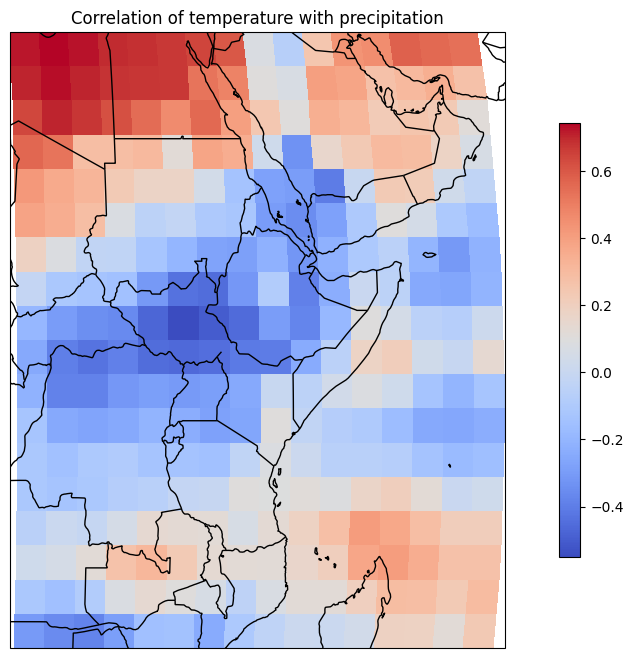

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="temperature"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of evaporation with precipitation')

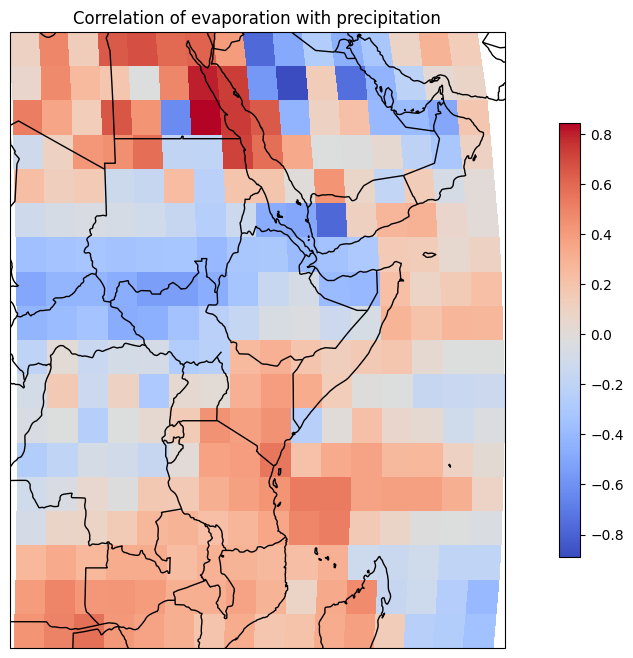

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="evaporation"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of geopotential with precipitation')

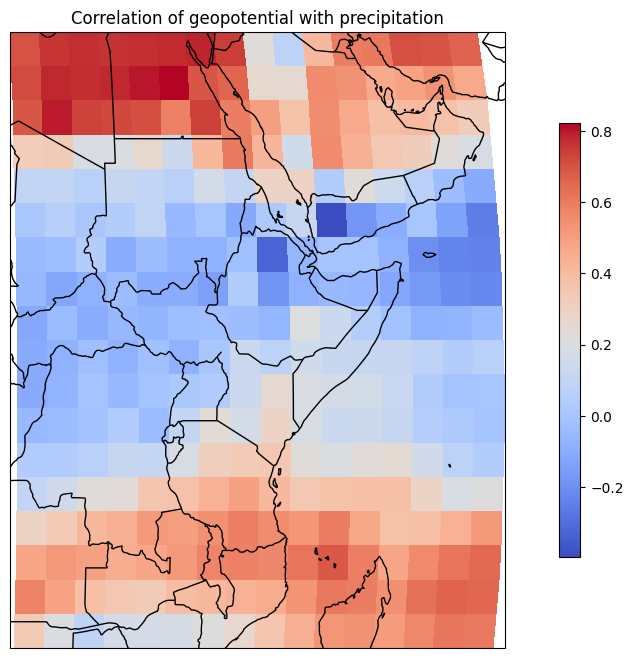

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="geopotential"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_ice_water_content with precipitation')

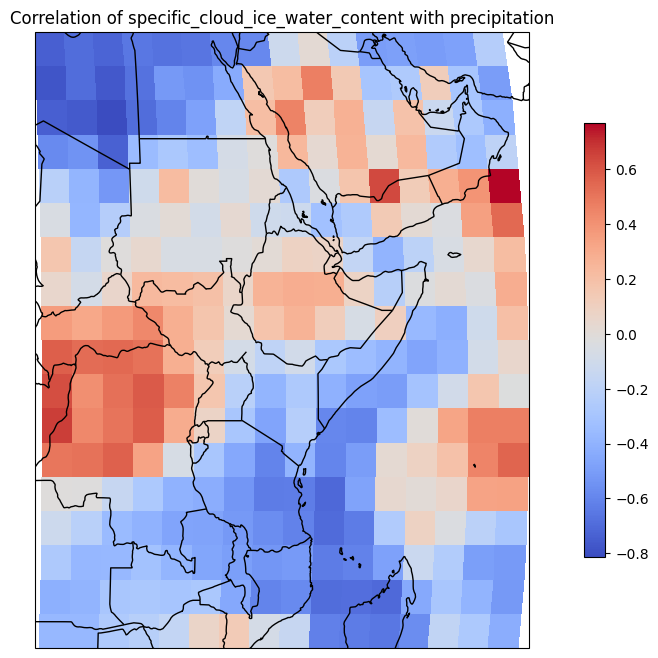

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_ice_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_liquid_water_content with precipitation')

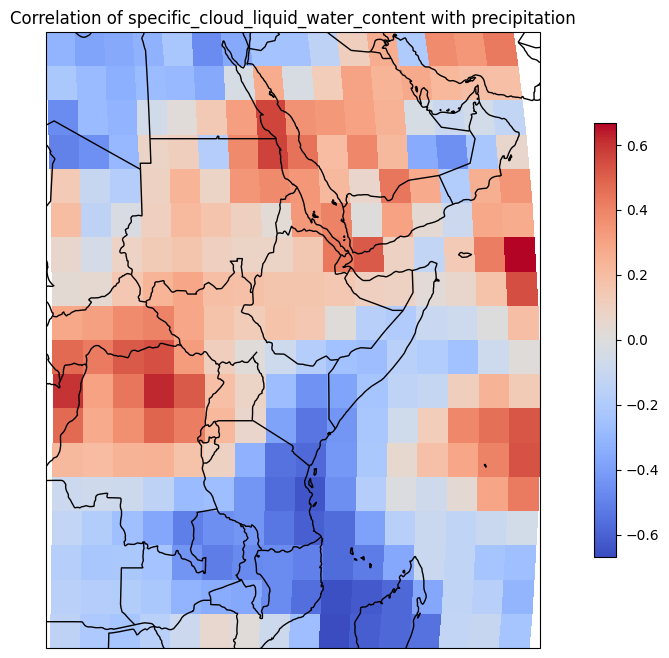

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_liquid_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_humidity with precipitation')

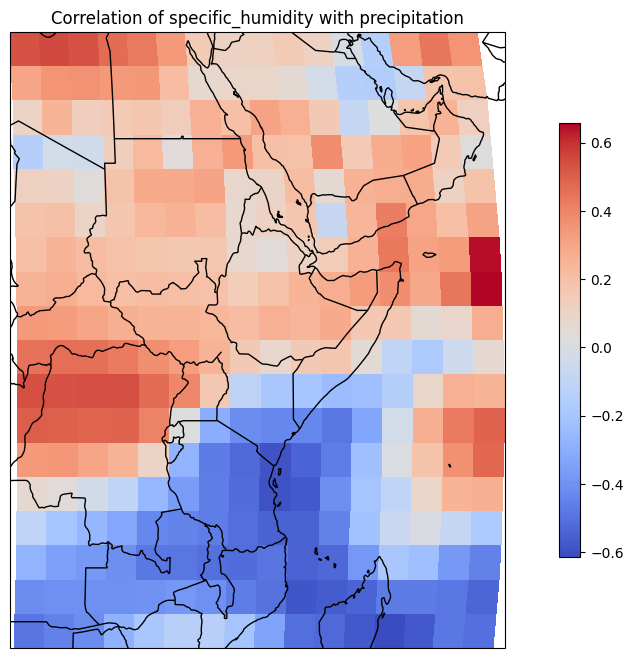

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_humidity"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of u_component_of_wind with precipitation')

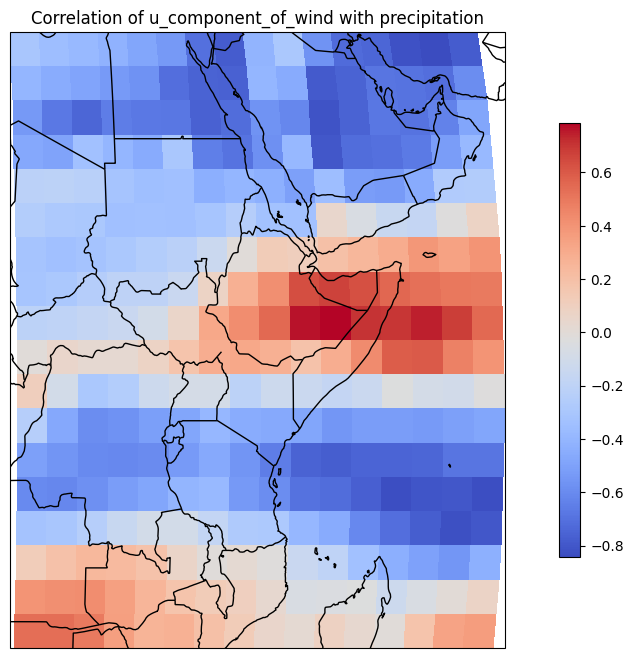

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="u_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of v_component_of_wind with precipitation')

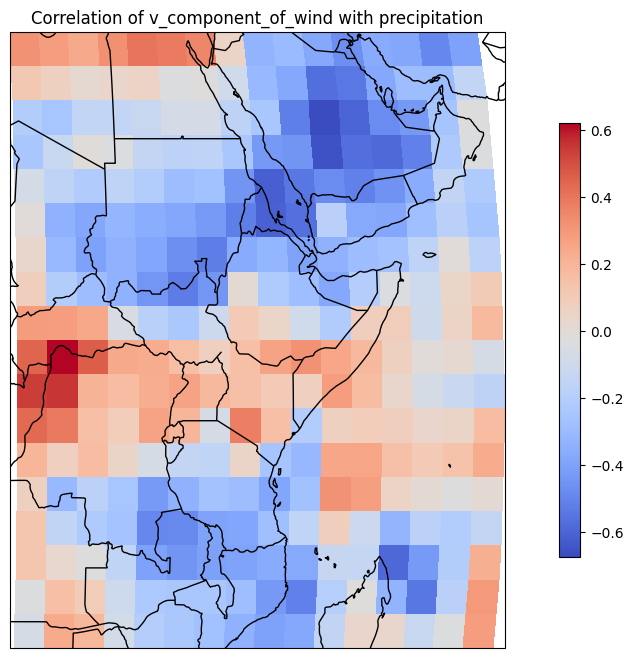

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="v_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

#correlation per year

In [ ]:
# prompt: selectiopnne la surface 1 ds_subset_1 et tu affectes au meme dataset

ds_subset_1 = ds_subset_1.sel(surface=1)
ds_subset_1

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
    surface                              int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
small_data=ds_subset_1

In [ ]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [ ]:
#  compute the group of variable per year
evaporation_group_year = small_data.evaporation.groupby(small_data.date.dt.year)
temperature_group_year = small_data.temperature.groupby(small_data.date.dt.year)
geopotential_group_year= small_data.geopotential.groupby(small_data.date.dt.year)
precipitation_cumulative_mean_group_year= small_data.precipitation_cum_6h.groupby(small_data.date.dt.year)
specific_cloud_ice_water_content_group_year= small_data.specific_cloud_ice_water_content.groupby(small_data.date.dt.year)
specific_cloud_liquid_water_content_group_year= small_data.specific_cloud_liquid_water_content.groupby(small_data.date.dt.year)
specific_humidity_group_year= small_data.specific_humidity.groupby(small_data.date.dt.year)
u_component_of_wind_group_year= small_data.u_component_of_wind.groupby(small_data.date.dt.year)
v_component_of_wind_group_year= small_data.v_component_of_wind.groupby(small_data.date.dt.year)


In [ ]:
# prompt: creer un dataset avec toutes les valeurs moyennes obtenues

# Calculate the mean for each group
evaporation_mean = evaporation_group_year.mean(dim='date')
temperature_mean = temperature_group_year.mean(dim='date')
geopotential_mean = geopotential_group_year.mean(dim='date')
precipitation_cumulative_mean_mean = precipitation_cumulative_mean_group_year.mean(dim='date')
specific_cloud_ice_water_content_mean = specific_cloud_ice_water_content_group_year.mean(dim='date')
specific_cloud_liquid_water_content_mean = specific_cloud_liquid_water_content_group_year.mean(dim='date')
specific_humidity_mean = specific_humidity_group_year.mean(dim='date')
u_component_of_wind_mean = u_component_of_wind_group_year.mean(dim='date')
v_component_of_wind_mean = v_component_of_wind_group_year.mean(dim='date')


# Create a dictionary to store the mean variables
mean_vars = {
    'evaporation': evaporation_mean,
    'temperature': temperature_mean,
    'geopotential': geopotential_mean,
    'precipitation_cumulative_mean': precipitation_cumulative_mean_mean,
    'specific_cloud_ice_water_content': specific_cloud_ice_water_content_mean,
    'specific_cloud_liquid_water_content': specific_cloud_liquid_water_content_mean,
    'specific_humidity': specific_humidity_mean,
    'u_component_of_wind': u_component_of_wind_mean,
    'v_component_of_wind': v_component_of_wind_mean
}

# Create the dataset
mean_dataset = xr.Dataset(mean_vars)

# Print the resulting dataset
mean_dataset

<xarray.Dataset> Size: 208kB
Dimensions:                              (latitude: 18, longitude: 16, year: 20)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    surface                              int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * year                                 (year) int64 160B 2001 2002 ... 2020
Data variables:
    evaporation                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Assuming 'mean_dataset' contains your yearly averaged data
# # and 'precipitation_cumulative_mean' is the target variable

# # Get the list of variables to correlate against precipitation
# variables = [var for var in mean_dataset.data_vars if var != 'precipitation_cumulative_mean']

# # Loop through each variable and calculate/plot the correlation
# for var in variables:
#     correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[var], dim='year')

#     plt.figure(figsize=(12, 6))
#     ax = plt.axes(projection=ccrs.PlateCarree())

#     # Get coordinates properly
#     lons = correlation.longitude.values
#     lats = correlation.latitude.values
#     lat_min, lat_max = float(correlation.latitude.min()), float(correlation.latitude.max())
#     lon_min, lon_max = float(correlation.longitude.min()), float(correlation.longitude.max())
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#     # Plot correlation with proper parameters
#     im = correlation.plot(
#         ax=ax,
#         transform=ccrs.PlateCarree(),
#         cmap='coolwarm',
#         cbar_kwargs={'label': f'Correlation with precipitation'},
#         add_labels=False  # Évite les conflits avec cartopy
#     )

#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS)
#     ax.set_title(f'Correlation of {var} with precipitation')

#     plt.show()

In [ ]:
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year')
correlation

<xarray.DataArray (longitude: 16, latitude: 18)> Size: 1kB
dask.array<truediv, shape=(16, 18), dtype=float32, chunksize=(16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 144B -18.14 -15.35 -12.56 ... 23.72 26.51 29.3
  * longitude  (longitude) float64 128B 16.88 19.69 22.5 ... 53.44 56.25 59.06
    surface    int64 8B 1
    level      int64 8B 500
    time       datetime64[ns] 8B 2001-12-27

In [ ]:
evaporation_prep_cor = correlation.values
evaporation_prep_cor

array([[-7.69309163e-01, -6.30026996e-01, -5.50259650e-01,
        -5.84957004e-01, -4.27617550e-01, -2.94159472e-01,
        -3.45014989e-01, -2.87865311e-01, -2.21956894e-02,
        -4.03825976e-02, -3.34660172e-01, -3.66577983e-01,
        -4.36601102e-01, -7.51910567e-01, -6.61340952e-01,
        -3.83111477e-01, -4.07025486e-01, -6.47238135e-01],
       [-4.01170790e-01, -3.32084149e-01, -4.26988482e-01,
        -3.61112535e-01, -3.13202292e-01, -2.00931981e-01,
        -2.74973184e-01, -4.04905260e-01, -3.03407103e-01,
        -9.24874842e-02, -5.94448075e-02, -2.23503545e-01,
        -4.11999047e-01, -7.04170227e-01, -7.05543578e-01,
        -4.07422125e-01, -2.68704087e-01, -6.01253092e-01],
       [-1.59182325e-01, -3.84954751e-01, -3.40159506e-01,
        -2.17385471e-01, -2.88769692e-01, -2.18305886e-01,
        -2.68067479e-01, -2.60691673e-01, -4.91332918e-01,
        -5.05715869e-02,  1.64507911e-01, -1.32032841e-01,
        -5.44739246e-01, -7.48866260e-01, -8.53965402e

In [ ]:
evaporation_prep_cor

Longitude shape: (16,)
Latitude shape: (18,)


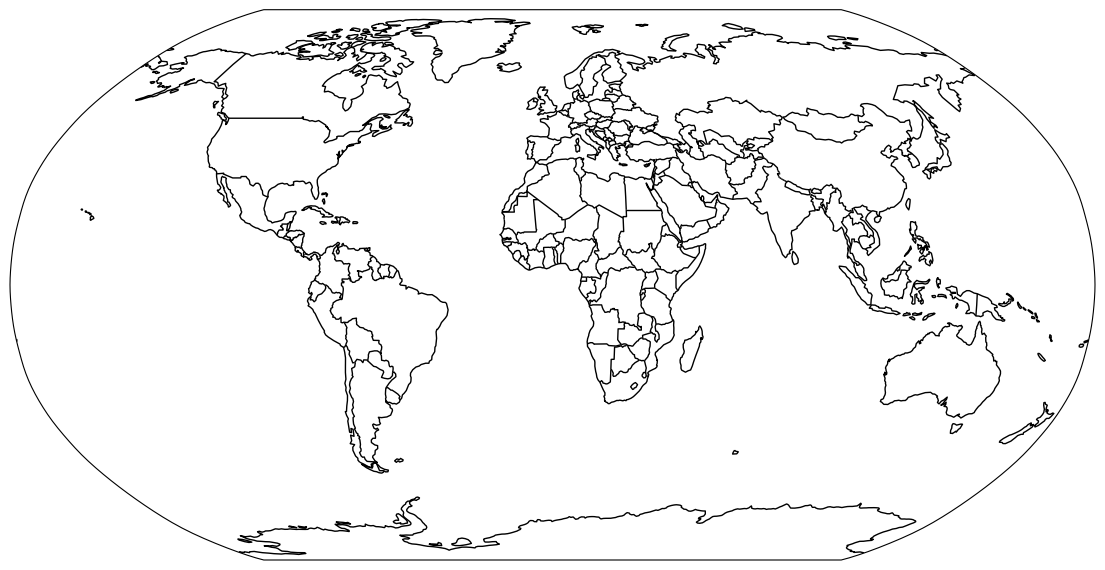

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np



correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year')

fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

# Access the first item in the correlations dictionary to get an xarray DataArray
# Then access its longitude and latitude coordinates

lons = correlation.longitude.values
lats = correlation.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")


ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
evaporation_prep_cor = correlation.values.item()
c = plt.pcolormesh(lons, lats, evaporation_prep_cor.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


variables = [var for var in mean_dataset.data_vars if var != 'precipitation_cumulative_mean']

# Loop through each variable and calculate/plot the correlation
for var in variables
  correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[var], dim='year')

  plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())
  lons = correlation.longitude.values
  lats = correlation.latitude.values
  lat_min, lat_max = correlation.latitude.min(), correlation.latitude.max()
  lon_min, lon_max = correlation.longitude.min(), correlation.longitude.max()
  ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

  correlation.plot(
      ax=ax,
      transform=ccrs.PlateCarree(),
      cmap='coolwarm',  # Choose a suitable colormap
      cbar_kwargs={'label': f'Correlation with precipitation'},
  )

  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.BORDERS)
  ax.set_title(f'Correlation of {var} with precipitation')

  plt.show()


fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

# Access the first item in the correlations dictionary to get an xarray DataArray
# Then access its longitude and latitude coordinates
first_variable = list(correlations.keys())[7]
lons = correlations[first_variable].longitude.values
lats = correlations[first_variable].latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")


# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the mean along the 'prediction_timedelta' dimension
# geopotential_mean = correlations[first_variable].values.item()
# # geopotential_mean
# print(f"Data shape: {geopotential_mean.shape}")
# c = plt.pcolormesh(lons, lats, geopotential_mean.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

# cb = plt.colorbar(c, fraction=0.02)


In [ ]:
mean_dataset

<xarray.Dataset> Size: 208kB
Dimensions:                              (latitude: 18, longitude: 16, year: 20)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    surface                              int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * year                                 (year) int64 160B 2001 2002 ... 2020
Data variables:
    evaporation                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="evaporation"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of temperature with precipitation')

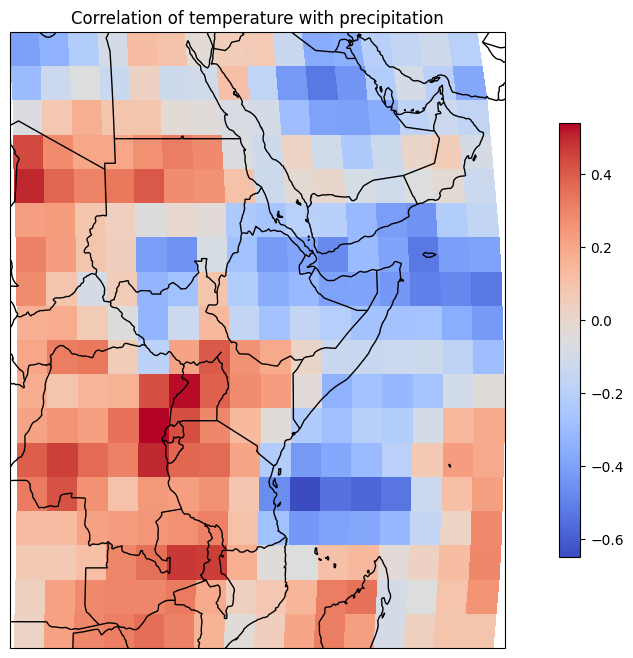

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="temperature"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of geopotential with precipitation')

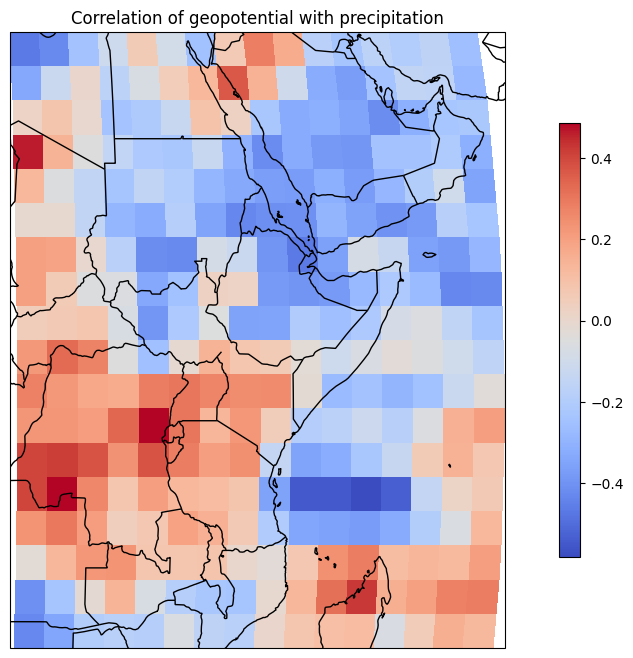

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="geopotential"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_ice_water_content with precipitation')

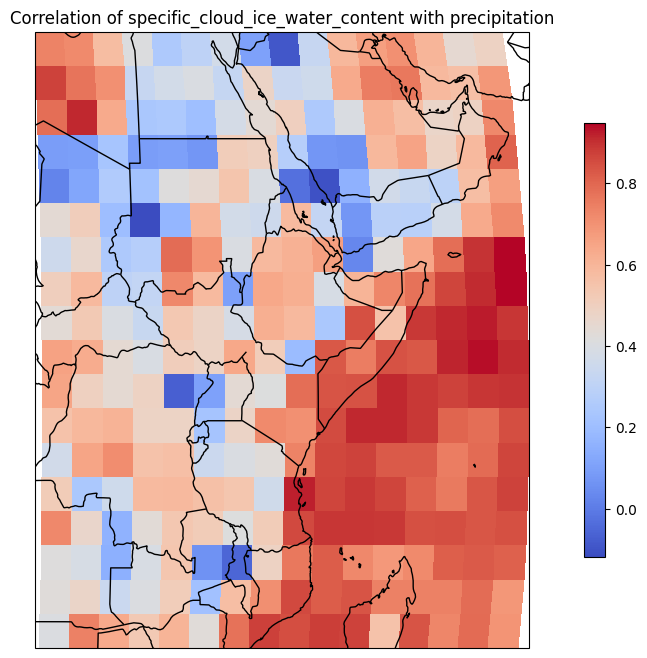

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_ice_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_liquid_water_content with precipitation')

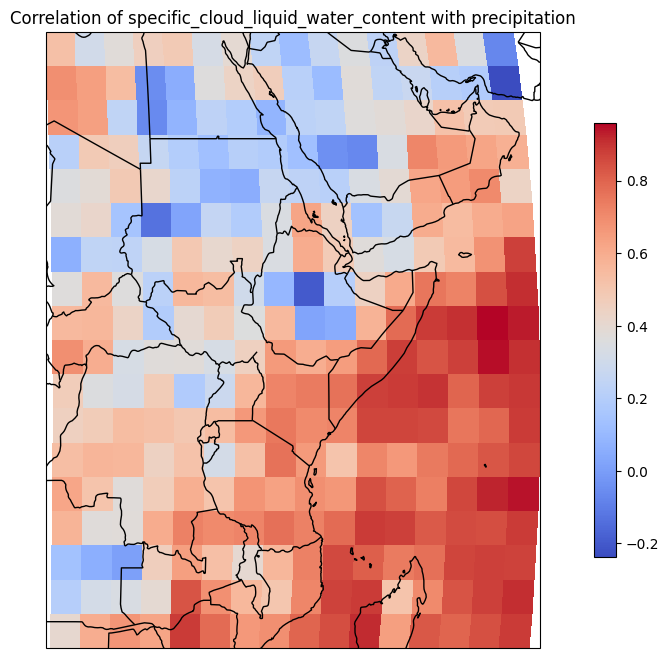

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_liquid_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_humidity with precipitation')

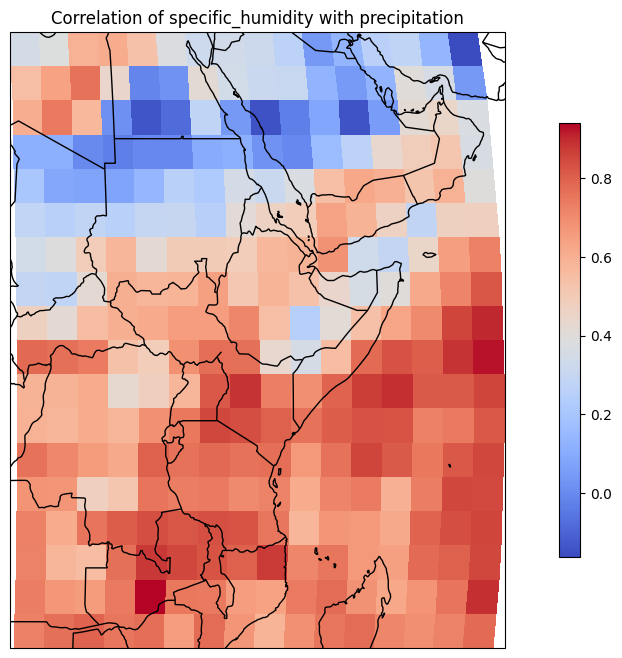

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_humidity"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of u_component_of_wind with precipitation')

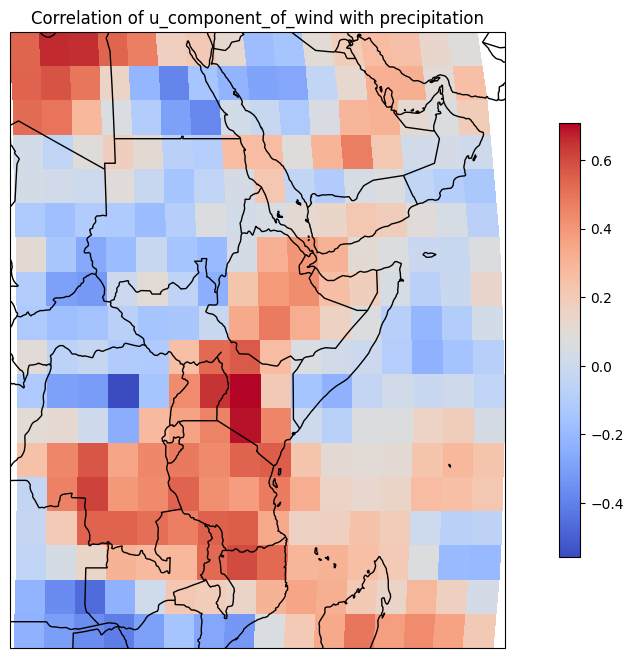

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="u_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of v_component_of_wind with precipitation')

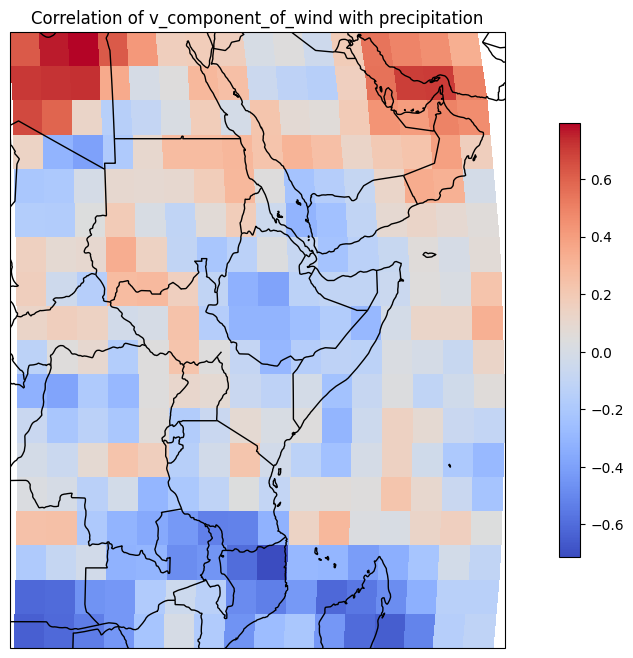

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="v_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable} with precipitation')

FILE GENERATION

In [ ]:
selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
#Sélect one level and one surface(surface=1, level=0)
mean_dataset=[]
max_dataset=[]
min_dataset=[]
std_dataset=[]
small_data= selected_data.sel(time=selected_data.time[-1],surface=selected_data.surface[0])
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})
year_2018_data = small_data.sel(date=slice('2018-01-01', '2018-12-31'))
year_2018_data

# for i in selected_data.level:
#   mean_dataset.append(year_2018_data.sel(level=i).groupby('date.year').mean(dim=('date','longitude','latitude')))


<xarray.Dataset> Size: 39MB
Dimensions:                              (date: 1460, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 12kB 6209 day...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 12kB 2018-01-0...
Data variables:
    evaporation                          (date, longitude, latitude) float32 2MB dask.array<chunksize=(4, 16, 18), meta=np.ndarray>
    geopotential                         (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, longitude, latitude) float32 2MB dask.array<chunksize=(4, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    temperature                          (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, level, longitude, latitude) float32 5MB dask.array<chunksize=(4, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
# prompt: selectionner le min , le max , calculer la moyenne et la standard deviation de toutes les varaibles presente ,tu dois creer un dictionnaire qui contient les resultats c'est pas correct il doit avoir la parie de la selection du level

import xarray as xr
import pandas as pd

# Assuming 'selected_data' is your xarray Dataset

# 1. Create the date dimension:
base_date = pd.Timestamp('2001-01-01')
dates = base_date + selected_data.prediction_timedelta.values
selected_data = selected_data.assign_coords(date=('prediction_timedelta', dates))
selected_data = selected_data.swap_dims({'prediction_timedelta': 'date'})
# selected_data=selected_data.sel(surface=selected_data.surface[0])

results = {}

for level in selected_data.level:
  level_data = selected_data.sel(level=level).sel(date=slice('2018-01-01', '2018-12-31'))

  #drop date before grouping
  level_data = level_data.drop_vars('date')

  level_results = {}
  for var in level_data.data_vars:

    level_results[var] = {
        'min': level_data[var].groupby('date.year').min(dim=('date','longitude','latitude')).values,
        'max': level_data[var].groupby('date.year').max(dim=('date','longitude','latitude')).values,
        'mean': level_data[var].groupby('date.year').mean(dim=('date','longitude','latitude')).values,
        'std': level_data[var].groupby('date.year').std(dim=('date','longitude','latitude')).values
    }
  results[f"level_{level.values}"] = level_results



# #Now 'results' is a dictionary where keys are levels and values are dictionaries
#containing statistics for each variable at that level.
# Example to access:
# results['level_100']['temperature']['mean'] # mean temperature at level 100 hPa

KeyError: 'date'

In [ ]:
dictio

{'evaporation': {'mean': <xarray.DataArray 'evaporation' (year: 1)> Size: 4B
  dask.array<stack, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
  Coordinates:
      surface  int64 8B 1
      time     datetime64[ns] 8B 2001-12-27
    * year     (year) int64 8B 2018,
  'max': <xarray.DataArray 'evaporation' (year: 1)> Size: 4B
  dask.array<stack, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
  Coordinates:
      surface  int64 8B 1
      time     datetime64[ns] 8B 2001-12-27
    * year     (year) int64 8B 2018,
  'std': <xarray.DataArray 'evaporation' (year: 1)> Size: 4B
  dask.array<stack, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
  Coordinates:
      surface  int64 8B 1
      time     datetime64[ns] 8B 2001-12-27
    * year     (year) int64 8B 2018,
  'min': <xarray.DataArray 'evaporation' (year: 1)> Size: 4B
  dask.array<stack, shape=(1,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
  Coordinates:
      s

In [ ]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [ ]:
small_data

<xarray.Dataset> Size: 303MB
Dimensions:                              (date: 29204, surface: 1,
                                          longitude: 16, latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
# prompt: modifie moi ce code pour que j'ai le grouby par mois juste pour l'anne 2018

import xarray as xr
import pandas as pd


small_data = selected_data.sel(level=selected_data.level[0],time=selected_data.time[-1])
# Step 3: Filter for 2018 and then group by month
year_2018_data = small_data.sel(date=slice('2018-01-01', '2018-12-31'))
mean_2018 = year_2018_data.groupby('date.year').mean(dim=('date','longitude','latitude'))

# Result
mean_2018.evaporation.values
#

KeyError: "'date' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'prediction_timedelta': 29204, 'surface': 1, 'longitude': 16, 'latitude': 18})"

In [ ]:
# prompt: suppose que j'a des varialbes ,la moyenne , le maximum ,std,et le minimum de ces variables ,
#   je veux cree un dictionnaire,en fait il faut que le nom de la variable soit dans le dictionnaire

variables = ['evaporation,', 'precipitation cumulative mean', 'u-component_of_wind'] # Example variable names
mean = [10, 20, 30] # Example mean values
maximum = [15, 25, 35] # Example maximum values
std = [2, 3, 4] # Example standard deviation values
minimum = [5, 15, 25] # Example minimum values


dictio = {}
for i, var in enumerate(variables):
  print(var)
  print(i)
  # dictio[var] = {'mean': mean[i], 'max': maximum[i], 'std': std[i], 'min': minimum[i]}

# dictio

evaporation,
0
precipitation cumulative mean
1
u-component_of_wind
2


#2-select the second level

In [ ]:
# Sélect one level and one surface(surface=1, level=0)
ds_subset_2 = selected_data.sel(level=selected_data.level[0],time=selected_data.time[0])
ds_subset_2

In [ ]:
# Identify precipitation variable name (commonly 'tp' or 'precip')
precip_name = [var for var in ds_subset_2.data_vars if 'precip' in var or 'tp' in var][0]
precip = ds_subset_2[precip_name]

# We'll compare spatial correlation with all other variables
variables = list(ds_subset_2.data_vars)
variables.remove(precip_name)

correlations = {}

# Loop over all variables
for var_name in variables:
    var = ds_subset_2[var_name]

    # Align time dimension and compute temporal mean at each grid point
    var_ = var.sel(prediction_timedelta=precip.prediction_timedelta)

    # Flatten lat-lon and compute correlation between time series
    precip_2d = precip.stack(z=("latitude", "longitude"))
    var_2d = var_.stack(z=("latitude", "longitude"))

    # Remove nan
    valid = (~np.isnan(precip_2d)).all("prediction_timedelta") & (~np.isnan(var_2d)).all("prediction_timedelta").values
    print(valid)

    # Compute correlation across time
    corr = xr.corr(var_2d.sel(z=valid), precip_2d.sel(z=valid), dim="prediction_timedelta")

    correlations[var_name] = corr

# Display correlations
for var, corr in correlations.items():
    print(f"{var} vs {precip_name}: mean corr = {corr.mean().item():.4f}")


In [ ]:
# Définir le device (GPU si disponible, sinon CPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# # tenir compte de la derniere valeur de time
# small_data = selected_data.isel(time=-1)
small_data=ds_subset_1

In [ ]:
small_data.nbytes/1e9

0.336664008

In [ ]:
small_data

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
small_data.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 06:00:00',
                   '0 days 12:00:00',    '0 days 18:00:00',
                   '1 days 00:00:00',    '1 days 06:00:00',
                   '1 days 12:00:00',    '1 days 18:00:00',
                   '2 days 00:00:00',    '2 days 06:00:00',
                ...
                '7298 days 12:00:00', '7298 days 18:00:00',
                '7299 days 00:00:00', '7299 days 06:00:00',
                '7299 days 12:00:00', '7299 days 18:00:00',
                '7300 days 00:00:00', '7300 days 06:00:00',
                '7300 days 12:00:00', '7300 days 18:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=29204, freq=None)

In [ ]:
import pandas as pd
import numpy as np

# Base time
base_time = pd.Timestamp(small_data.time.min().values)

#
timedeltas = pd.to_timedelta(small_data.prediction_timedelta.values)

# Create the values
dates = base_time + timedeltas

# Create the dataframe for the date
df_dates = pd.DataFrame({
    "timedelta": timedeltas,
    "date": dates
})

# print the dataframe
df_dates.head(10)


timedelta                date
0 0 days 00:00:00 2001-12-27 00:00:00
1 0 days 06:00:00 2001-12-27 06:00:00
2 0 days 12:00:00 2001-12-27 12:00:00
3 0 days 18:00:00 2001-12-27 18:00:00
4 1 days 00:00:00 2001-12-28 00:00:00
5 1 days 06:00:00 2001-12-28 06:00:00
6 1 days 12:00:00 2001-12-28 12:00:00
7 1 days 18:00:00 2001-12-28 18:00:00
8 2 days 00:00:00 2001-12-29 00:00:00
9 2 days 06:00:00 2001-12-29 06:00:00

In [ ]:
#save the dataframe of the date

df_dates.to_csv('dates_dataframe.csv', index=False)
print("DataFrame saved to dates_dataframe.csv")

DataFrame saved to dates_dataframe.csv


In [ ]:
small_data.prediction_timedelta.dt.days

<xarray.DataArray 'days' (prediction_timedelta: 29204)> Size: 234kB
array([   0,    0,    0, ..., 7300, 7300, 7300])
Coordinates:
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 234kB 00:00:...
    level                 int64 8B 500
    time                  datetime64[ns] 8B 2001-12-27

In [ ]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [ ]:
small_data

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          date: 29204, surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
small_data.evaporation.groupby(small_data.date.dt.year)

<DataArrayGroupBy, grouped over 1 grouper(s), 20 groups in total:
    'year': 20/20 groups present with labels 2001, 2002, 2003, ..., 2019, 2020>

In [ ]:
#compute the group of variable per year
evaporation_group_year = small_data.evaporation.groupby(small_data.date.dt.year)
temperature_group_year = small_data.temperature.groupby(small_data.date.dt.year)
geopotential_group_year= small_data.geopotential.groupby(small_data.date.dt.year)
precipitation_cumulative_mean_group_year= small_data.precipitation_cum_6h.groupby(small_data.date.dt.year)
specific_cloud_ice_water_content_group_year= small_data.specific_cloud_ice_water_content.groupby(small_data.date.dt.year)
specific_cloud_liquid_water_content_group_year= small_data.specific_cloud_liquid_water_content.groupby(small_data.date.dt.year)
specific_humidity_group_year= small_data.specific_humidity.groupby(small_data.date.dt.year)
u_component_of_wind_group_year= small_data.u_component_of_wind.groupby(small_data.date.dt.year)
v_component_of_wind_group_year= small_data.v_component_of_wind.groupby(small_data.date.dt.year)



In [ ]:
len(evaporation_group_year)

20

In [ ]:
evaporation_group_year[2001]

<xarray.DataArray 'evaporation' (date: 1460, surface: 1, longitude: 16,
                                 latitude: 18)> Size: 2MB
dask.array<getitem, shape=(1460, 1, 16, 18), dtype=float32, chunksize=(7, 1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
    prediction_timedelta  (date) timedelta64[ns] 12kB 0 days 00:00:00 ... 364...
  * surface               (surface) int64 8B 1
    level                 int64 8B 500
    time                  datetime64[ns] 8B 2001-12-27
  * date                  (date) datetime64[ns] 12kB 2001-01-01 ... 2001-12-3...

In [ ]:
evaporation_group_year[2001].mean(dim=('date','longitude','latitude')).values[0]

KeyboardInterrupt: 

In [ ]:
# Access the group for the year 2001
# evaporation_group_year[2001]

# To get the first group (which corresponds to the earliest year, 2001 in this case)
# You can access the keys using .groups and get the first key
first_year = list(evaporation_group_year.groups.keys())[0]
print(f"The first year available is: {first_year}")

# Access the first group using the first year as the key
evaporation_group_year[first_year]



The first year available is: 2001


<xarray.DataArray 'evaporation' (time: 37, date: 1460, surface: 1,
                                 longitude: 16, latitude: 18)> Size: 62MB
dask.array<getitem, shape=(37, 1460, 1, 16, 18), dtype=float32, chunksize=(1, 7, 1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
    level                 int64 8B 500
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
    prediction_timedelta  (date) timedelta64[ns] 12kB 0 days 00:00:00 ... 364...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27
  * date                  (date) datetime64[ns] 12kB 2001-01-01 ... 2001-12-3...

In [ ]:
# #compute the mean of each variables per year
# import tqdm as tqdm
# evaporation_mean_year=[]
# for i in tqdm.tqdm(range(len(evaporation_group_year))):
#   evaporation_mean_year.append(evaporation_group_year[i].mean(dim=('date','longitude','latitude')).values[0])

In [ ]:
import tqdm

evaporation_mean_year = []
years = range(2001, 2021)
years

range(2001, 2021)

In [ ]:
#  # From 2001 to 2020 inclusive

# for year in tqdm.tqdm(years):
#     evaporation_mean_year.append(evaporation_group_year[year].mean(dim=('date','longitude','latitude')).values[0])

In [ ]:
temperature_mean_year=[]
for year in tqdm.tqdm(years):
    temperature_mean_year.append(temperature_group_year[year].mean(dim=('date','longitude','latitude')).values.item())

100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


In [ ]:
temperature_mean_year

[266.93768310546875,
 267.3570861816406,
 267.1766052246094,
 267.8168029785156,
 267.5619201660156,
 267.23931884765625,
 266.93231201171875,
 267.1047058105469,
 267.9026184082031,
 267.29730224609375,
 267.23394775390625,
 267.3265380859375,
 267.737548828125,
 267.1253356933594,
 267.8535461425781,
 267.9854736328125,
 267.28863525390625,
 267.9852600097656,
 267.6973571777344,
 267.9258117675781]

In [ ]:
geopotential_mean_year=[]
for year in tqdm.tqdm(years):
    geopotential_mean_year.append(geopotential_group_year[year].mean(dim=('date','longitude','latitude')).values[0])

In [ ]:
precipitation_cumulative_mean_mean_year=[]
for i in tqdm.tqdm(year):
  precipitation_cumulative_mean_mean_year.append(precipitation_cumulative_mean_group_year[i].mean(dim=('date','longitude','latitude')).values[0])

In [ ]:
specific_cloud_ice_water_content_mean_year=[]
for i in tqdm.tqdm(years):
  specific_cloud_ice_water_content_mean_year.append(specific_cloud_ice_water_content_group_year[i].mean(dim=('date','longitude','latitude')).values[0])

In [ ]:

# Create a pandas Series for easier plotting
evaporation_series = pd.Series(evaporation_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines

# Annotate each point with its actual value
for i, year in enumerate(years):
    plt.annotate(f'{evaporation_mean_year[i]:.2f}', (year, evaporation_mean_year[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Time Series of Mean Evaporation', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


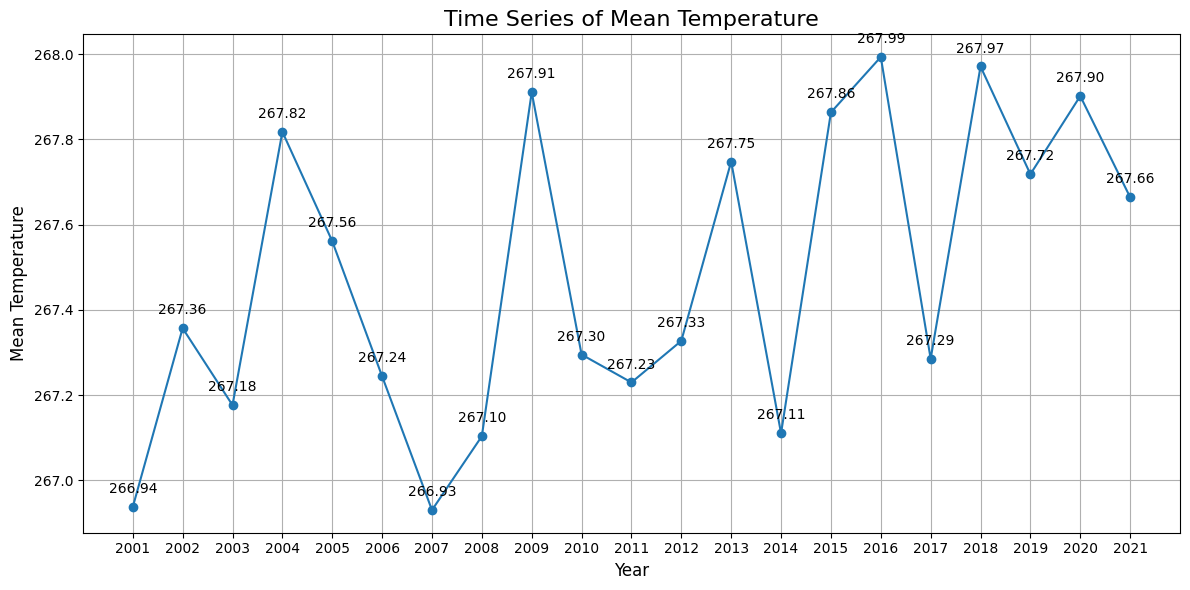

In [ ]:

# Create a pandas Series for easier plotting
temperature_series = pd.Series(temperature_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, temperature_series.values, marker='o', linestyle='-')  # Add markers and lines

# Annotate each point with its value
for i, txt in enumerate(temperature_mean_year):
    plt.annotate(f"{txt:.2f}", (years[i], temperature_series.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Time Series of Mean Temperature', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Temperature', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


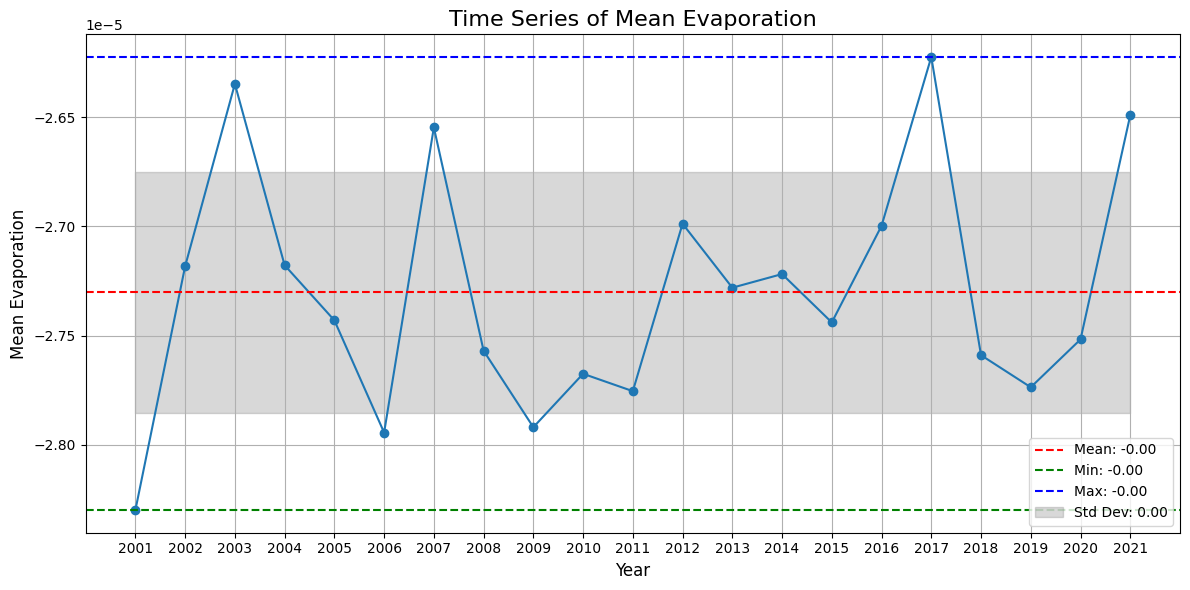

In [ ]:

# Create a pandas Series for easier plotting
evaporation_series = pd.Series(evaporation_mean_year)

# Calculate statistics
mean_evaporation = evaporation_series.mean()
min_evaporation = evaporation_series.min()
max_evaporation = evaporation_series.max()
std_evaporation = evaporation_series.std()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines

# Add horizontal lines for mean, min, max, and std
plt.axhline(mean_evaporation, color='red', linestyle='--', label=f'Mean: {mean_evaporation:.2f}')
plt.axhline(min_evaporation, color='green', linestyle='--', label=f'Min: {min_evaporation:.2f}')
plt.axhline(max_evaporation, color='blue', linestyle='--', label=f'Max: {max_evaporation:.2f}')

plt.fill_between(years, mean_evaporation - std_evaporation, mean_evaporation + std_evaporation, color='gray', alpha=0.3, label=f'Std Dev: {std_evaporation:.2f}')


plt.title('Time Series of Mean Evaporation', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.legend() # Show the legend for the lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# Function to plot with annotations and statistics
def plot_with_stats(data, title, ylabel):
    series = pd.Series(data)
    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()

    plt.figure(figsize=(12, 6))
    plt.plot(years, series.values, marker='o', linestyle='-')

    for i, year in enumerate(years):
        plt.annotate(f'{data[i]:.2f}', (year, data[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axhline(min_val, color='green', linestyle='--', label=f'Min: {min_val:.2f}')
    plt.axhline(max_val, color='blue', linestyle='--', label=f'Max: {max_val:.2f}')
    plt.fill_between(years, mean_val - std_val, mean_val + std_val, color='gray', alpha=0.3, label=f'Std Dev: {std_val:.2f}')

    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.xticks(list(years))
    plt.legend()
    plt.tight_layout()
    plt.show()


# Call the function for Evaporation
plot_with_stats(evaporation_mean_year, 'Time Series of Mean Evaporation', 'Mean Evaporation')

# Call the function for Temperature
plot_with_stats(temperature_mean_year, 'Time Series of Mean Temperature', 'Mean Temperature')


In [ ]:
# Create a pandas Series for easier plotting
temperature_series = pd.Series(temperature_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines
plt.title('Time Series of Mean temperature', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping


plt.show()

In [ ]:
import tqdm
# Create a list to store the years
years = list(range(2001, 2021))

# Create empty lists to store the mean values for each variable
evaporation_means = []
temperature_means = []
geopotential_means = []
precipitation_means = []
specific_cloud_ice_water_content_means = []
specific_cloud_liquid_water_content_means = []
specific_humidity_means = []
u_component_of_wind_means = []
v_component_of_wind_means = []


# Assuming evaporation_group_year, etc., are defined as in your provided code
for year_index in tqdm.tqdm(years):
    evaporation_means.append(evaporation_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    temperature_means.append(temperature_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    geopotential_means.append(geopotential_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    precipitation_means.append(precipitation_cumulative_mean_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    specific_cloud_ice_water_content_means.append(specific_cloud_ice_water_content_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    specific_cloud_liquid_water_content_means.append(specific_cloud_liquid_water_content_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    specific_humidity_means.append(specific_humidity_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    u_component_of_wind_means.append(u_component_of_wind_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())
    v_component_of_wind_means.append(v_component_of_wind_group_year[year_index].mean(dim=('date', 'longitude', 'latitude')).values.item())




100%|██████████| 20/20 [28:04<00:00, 84.23s/it]


In [ ]:
#Create the DataFrame
df = pd.DataFrame({
    'Year': years,
    'Evaporation': evaporation_means,
    'Temperature': temperature_means,
    'Geopotential': geopotential_means,
    'Precipitation': precipitation_means,
    'Specific_Cloud_Ice_Water_Content': specific_cloud_ice_water_content_means,
    'Specific_Cloud_Liquid_Water_Content': specific_cloud_liquid_water_content_means,
    'Specific_Humidity': specific_humidity_means,
    'U_Component_of_Wind': u_component_of_wind_means,
    'V_Component_of_Wind': v_component_of_wind_means,
})

df

Year  Evaporation  Temperature  Geopotential  Precipitation  \
0   2001    -0.000028   266.937683  57505.875000       0.000527   
1   2002    -0.000027   267.357086  57568.625000       0.000586   
2   2003    -0.000026   267.176605  57550.144531       0.000519   
3   2004    -0.000027   267.816803  57620.148438       0.000567   
4   2005    -0.000027   267.561920  57570.980469       0.000603   
5   2006    -0.000028   267.239319  57503.238281       0.000564   
6   2007    -0.000027   266.932312  57443.734375       0.000524   
7   2008    -0.000028   267.104706  57553.781250       0.000568   
8   2009    -0.000028   267.902618  57621.113281       0.000529   
9   2010    -0.000028   267.297302  57481.964844       0.000542   
10  2011    -0.000028   267.233948  57537.917969       0.000628   
11  2012    -0.000027   267.326538  57558.304688       0.000580   
12  2013    -0.000027   267.737549  57631.054688       0.000538   
13  2014    -0.000027   267.125336  57579.718750       0.000555   
14  2015    -0.000027   267.853546  57664.339844       0.000509   
15  2016    -0.000027   267.985474  57645.019531       0.000518   
16  2017    -0.000026   267.288635  57562.390625       0.000546   
17  2018    -0.000028   267.985260  57648.097656       0.000603   
18  2019    -0.000028   267.697357  57591.660156       0.000570   
19  2020    -0.000027   267.925812  57591.257812       0.000512   

    Specific_Cloud_Ice_Water_Content  Specific_Cloud_Liquid_Water_Content  \
0                       1.068847e-06                             0.000009   
1                       9.435697e-07                             0.000009   
2                       9.096958e-07                             0.000008   
3                       8.056074e-07                             0.000009   
4                       9.640364e-07                             0.000009   
5                       9.812525e-07                             0.000009   
6                       9.446987e-07                             0.000009   
7                       1.019316e-06                             0.000009   
8                       8.262169e-07                             0.000009   
9                       9.692466e-07                             0.000009   
10                      1.080147e-06                             0.000010   
11                      9.317140e-07                             0.000009   
12                      8.286237e-07                             0.000009   
13                      9.181915e-07                             0.000009   
14                      7.765233e-07                             0.000009   
15                      8.043411e-07                             0.000009   
16                      8.964035e-07                             0.000009   
17                      9.304903e-07                             0.000010   
18                      9.099572e-07                             0.000009   
19                      8.157209e-07                             0.000009   

    Specific_Humidity  U_Component_of_Wind  V_Component_of_Wind  
0            0.001438             1.468133            -0.381264  
1            0.001538             1.563968            -0.309005  
2            0.001414             1.972763            -0.184781  
3            0.001551             1.793829            -0.307838  
4            0.001465             1.793342            -0.215174  
5            0.001535             1.620686            -0.425658  
6            0.001406             1.378363            -0.389773  
7            0.001431             1.987479            -0.496925  
8            0.001485             1.562606            -0.199163  
9            0.001408             1.321184            -0.221224  
10           0.001503             1.662144            -0.416535  
11           0.001459             2.043250            -0.376941  
12           0.001425             1.595228            -0.475999  
13           0.001483             1.411613            

In [ ]:

from google.colab import files
df.to_csv('NGCM_mean_6H_variables.csv', encoding = 'utf-8-sig')
files.download('NGCM_mean_6H_variables.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
# Load the dataframe from the CSV file
df = pd.read_csv('NGCM_mean_6H_variables.csv')
#remove the index column if present
df = df.drop(df.columns[0], axis=1)
df

Year  Evaporation  Temperature  Geopotential  Precipitation  \
0   2001    -0.000028   266.937683  57505.875000       0.000527   
1   2002    -0.000027   267.357086  57568.625000       0.000586   
2   2003    -0.000026   267.176605  57550.144531       0.000519   
3   2004    -0.000027   267.816803  57620.148438       0.000567   
4   2005    -0.000027   267.561920  57570.980469       0.000603   
5   2006    -0.000028   267.239319  57503.238281       0.000564   
6   2007    -0.000027   266.932312  57443.734375       0.000524   
7   2008    -0.000028   267.104706  57553.781250       0.000568   
8   2009    -0.000028   267.902618  57621.113281       0.000529   
9   2010    -0.000028   267.297302  57481.964844       0.000542   
10  2011    -0.000028   267.233948  57537.917969       0.000628   
11  2012    -0.000027   267.326538  57558.304688       0.000580   
12  2013    -0.000027   267.737549  57631.054688       0.000538   
13  2014    -0.000027   267.125336  57579.718750       0.000555   
14  2015    -0.000027   267.853546  57664.339844       0.000509   
15  2016    -0.000027   267.985474  57645.019531       0.000518   
16  2017    -0.000026   267.288635  57562.390625       0.000546   
17  2018    -0.000028   267.985260  57648.097656       0.000603   
18  2019    -0.000028   267.697357  57591.660156       0.000570   
19  2020    -0.000027   267.925812  57591.257812       0.000512   

    Specific_Cloud_Ice_Water_Content  Specific_Cloud_Liquid_Water_Content  \
0                       1.068847e-06                             0.000009   
1                       9.435697e-07                             0.000009   
2                       9.096958e-07                             0.000008   
3                       8.056074e-07                             0.000009   
4                       9.640364e-07                             0.000009   
5                       9.812525e-07                             0.000009   
6                       9.446987e-07                             0.000009   
7                       1.019316e-06                             0.000009   
8                       8.262169e-07                             0.000009   
9                       9.692466e-07                             0.000009   
10                      1.080147e-06                             0.000010   
11                      9.317140e-07                             0.000009   
12                      8.286237e-07                             0.000009   
13                      9.181915e-07                             0.000009   
14                      7.765233e-07                             0.000009   
15                      8.043411e-07                             0.000009   
16                      8.964035e-07                             0.000009   
17                      9.304903e-07                             0.000010   
18                      9.099572e-07                             0.000009   
19                      8.157209e-07                             0.000009   

    Specific_Humidity  U_Component_of_Wind  V_Component_of_Wind  
0            0.001438             1.468133            -0.381264  
1            0.001538             1.563968            -0.309005  
2            0.001414             1.972763            -0.184781  
3            0.001551             1.793829            -0.307838  
4            0.001465             1.793342            -0.215174  
5            0.001535             1.620686            -0.425658  
6            0.001406             1.378363            -0.389773  
7            0.001431             1.987479            -0.496925  
8            0.001485             1.562606            -0.199163  
9            0.001408             1.321184            -0.221224  
10           0.001503             1.662144            -0.416535  
11           0.001459             2.043250            -0.376941  
12           0.001425             1.595228            -0.475999  
13           0.001483             1.411613            

In [ ]:
import pandas as pd
# Load the dataframe from the CSV file
df = pd.read_csv('/content/horn_africa_ngcm_mean.csv')
#remove the index column if present
df = df.drop(df.columns[0], axis=1)
df

Evaporation  Temperature  Geopotential  Precipitation  \
0      0.000028    266.83950      5746.086       0.142148   
1      0.000027    267.36040      5754.567       1.144697   
2      0.000028    267.57040      5784.980       1.935824   
3      0.000027    267.03445      5725.062       2.783200   
4      0.000027    267.56100      5782.090       3.609016   
5      0.000027    267.03313      5750.700       4.397047   
6      0.000028    267.26553      5745.215       5.238017   
7      0.000027    266.76575      5743.410       6.085217   
8      0.000028    267.54560      5768.797       6.857293   
9      0.000028    267.68700      5797.895       7.738120   
10     0.000028    267.61710      5745.980       8.571581   
11     0.000028    267.35480      5729.050       9.425330   
12     0.000030    267.19550      5738.426      10.292000   
13     0.000027    267.69740      5778.150      11.110000   
14     0.000028    267.57385      5760.306      11.946110   
15     0.000028    267.77515      5768.650      12.779960   
16     0.000027    267.64100      5795.914      13.587130   
17     0.000027    267.09247      5750.653      14.339950   
18     0.000028    267.96230      5791.438      15.163070   
19     0.000027    267.76670      5762.117      16.086920   

    Specific_Cloud_Ice_Water_Content  Specific_Cloud_Liquid_Water_Content  \
0                       1.059396e-06                              0.00009   
1                       8.527810e-07                              0.00003   
2                       1.012370e-06                              0.00010   
3                       9.824460e-07                              0.00009   
4                       9.742560e-07                              0.00010   
5                       9.269790e-07                              0.00009   
6                       1.010680e-06                              0.00009   
7                       1.954600e-06                              0.00009   
8                       9.803250e-07                              0.00009   
9                       9.019200e-07                              0.00009   
10                      9.518750e-07                              0.00009   
11                      1.048280e-06                              0.00009   
12                      9.916100e-07                              0.00009   
13                      9.197820e-07                              0.00009   
14                      9.376020e-07                              0.00009   
15                      9.038160e-07                              0.00009   
16                      9.668510e-07                              0.00009   
17                      9.937340e-07                              0.00009   
18                      1.136940e-06                              0.00011   
19                      9.282740e-07                              0.00009   

    Specific_Humidity  U_Component_of_Wind  V_Component_of_Wind  
0            0.014430              1.35868            -0.171580  
1            0.001430              2.11720            -0.306700  
2            0.001060              1.75610            -0.371240  
3            0.001467              1.80480            -0.198515  
4            0.001560              1.87272            -0.266320  
5            0.001486              1.35573            -0.026330  
6            0.001522              1.47319            -0.312178  
7            0.001457              1.61108            -0.361670  
8            0.001524              1.70390            -0.262326  
9            0.001555              1.47296            -0.340520  
10           0.001559              1.22766            -0.316150  
11           0.001522              1.54073            -0.483474  
12           0.001505              1.83577            -0.280940  
13           0.001485              1.63107            -0.040680  
14           0.001496              1.77038            -0.398260  
15           0.001515              1.61419      

In [ ]:

# import matplotlib.pyplot as plt
# # Function to plot with annotations and statistics
# def plot_with_stats(data, title, ylabel):
#     series = pd.Series(data)
#     mean_val = series.mean()
#     min_val = series.min()
#     max_val = series.max()
#     std_val = series.std()
#     plt.figure(figsize=(12, 6))
#     plt.plot(years, series.values, marker='o', linestyle='-')
#     for i, year in enumerate(years):
#         plt.annotate(f'{data[i]:.2f}', (year, data[i]), textcoords="offset points", xytext=(0, 10), ha='center')
#     plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
#     plt.axhline(min_val, color='green', linestyle='--', label=f'Min: {min_val:.2f}')
#     plt.axhline(max_val, color='blue', linestyle='--', label=f'Max: {max_val:.2f}')
#     plt.fill_between(years, mean_val - std_val, mean_val + std_val, color='gray', alpha=0.3, label=f'Std Dev: {std_val:.2f}')
#     plt.title(title, fontsize=16)
#     plt.xlabel('Year', fontsize=12)
#     plt.ylabel(ylabel, fontsize=12)
#     plt.grid(True)
#     plt.xticks(list(years))
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Example usage with the dataframe:
# years = df['Year'].values.tolist()

# # Plotting for each variables
# for col in df.columns:
#     if col != 'Year':
#         plot_with_stats(df[col].values.tolist(), f'Time Series of {col}', col)


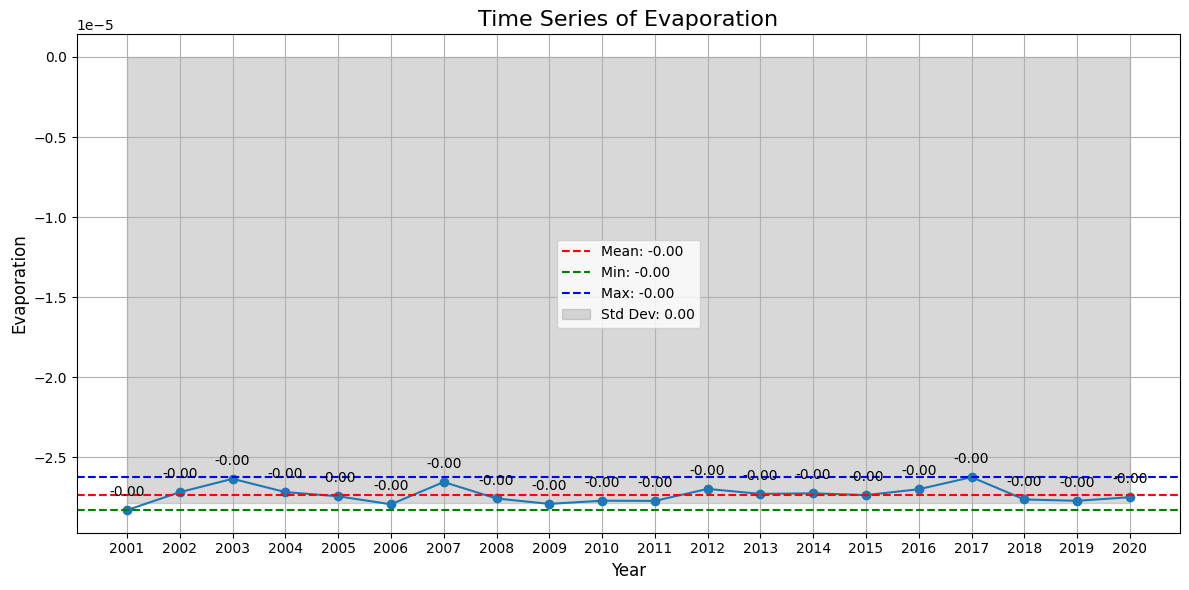

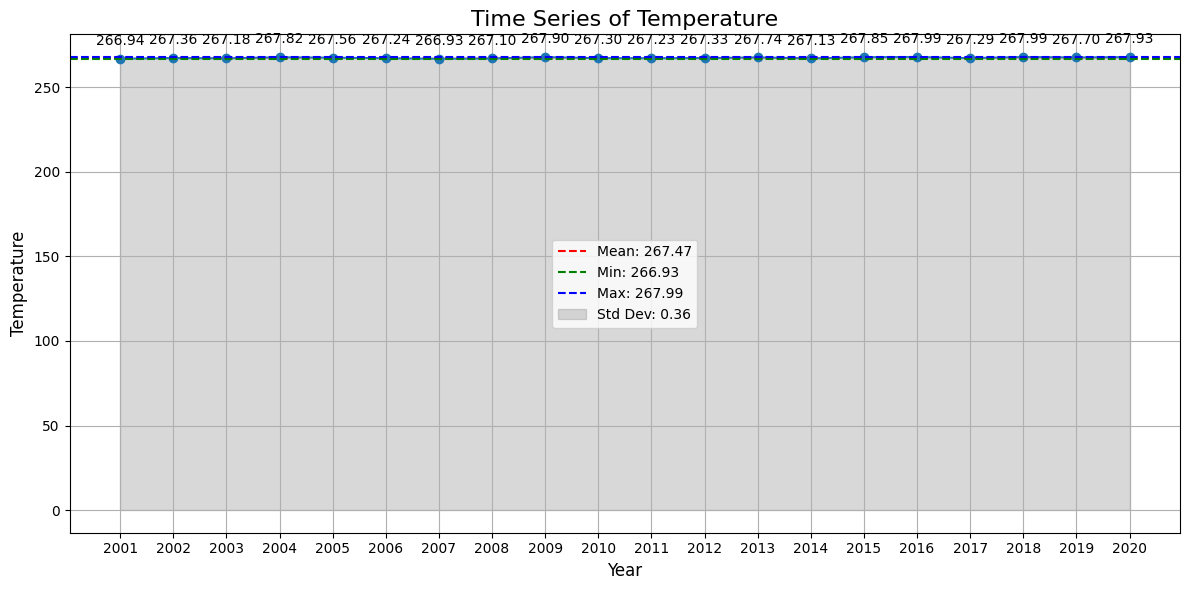

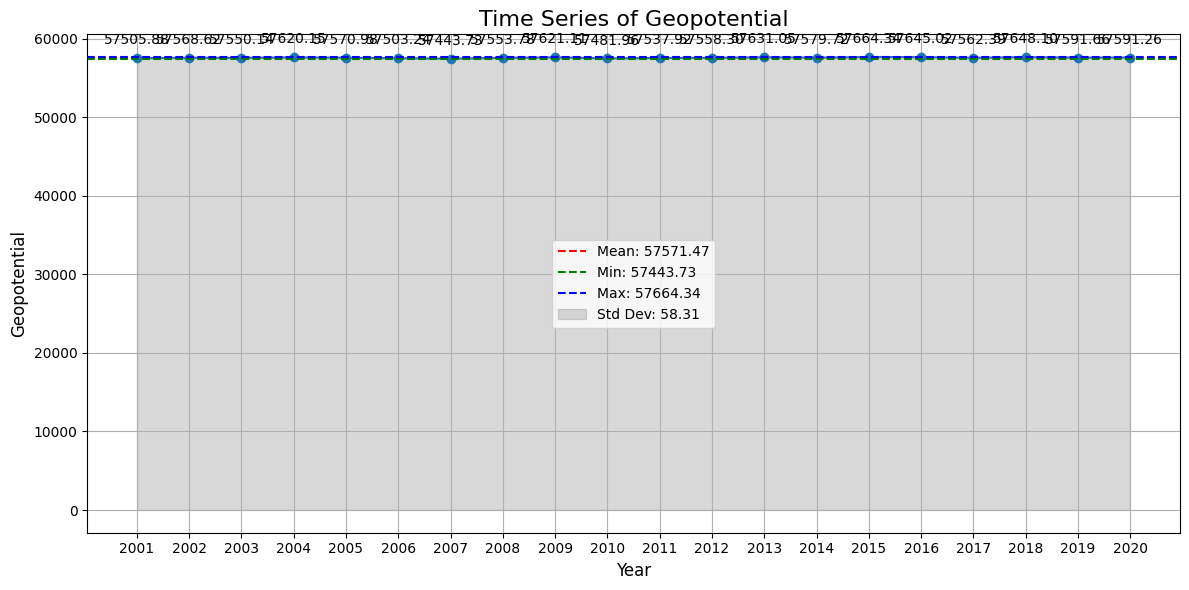

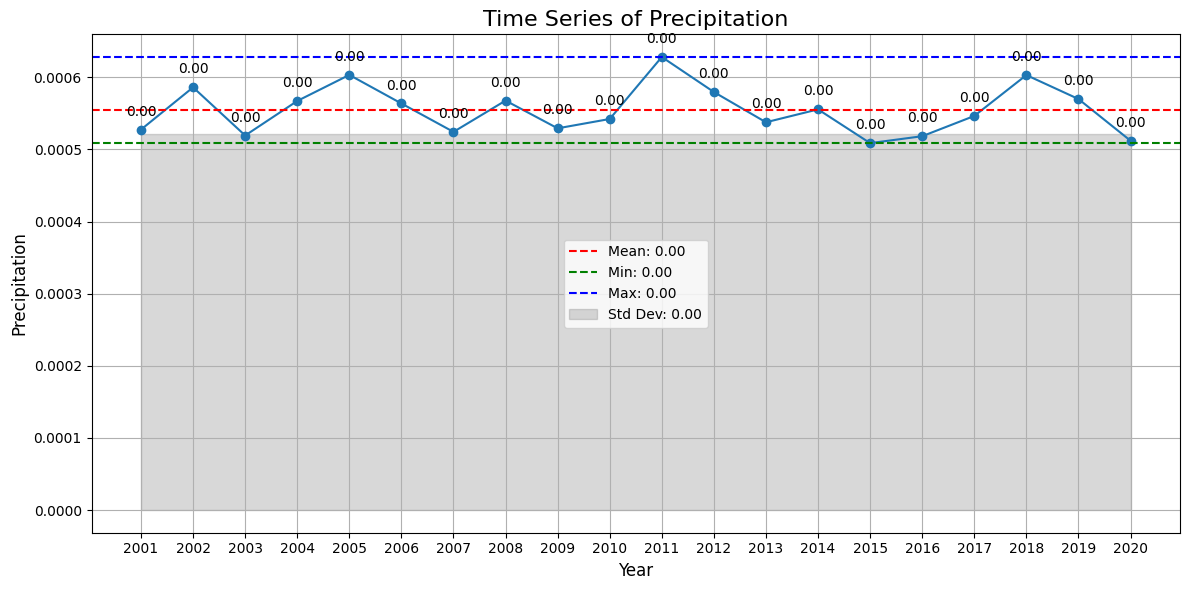

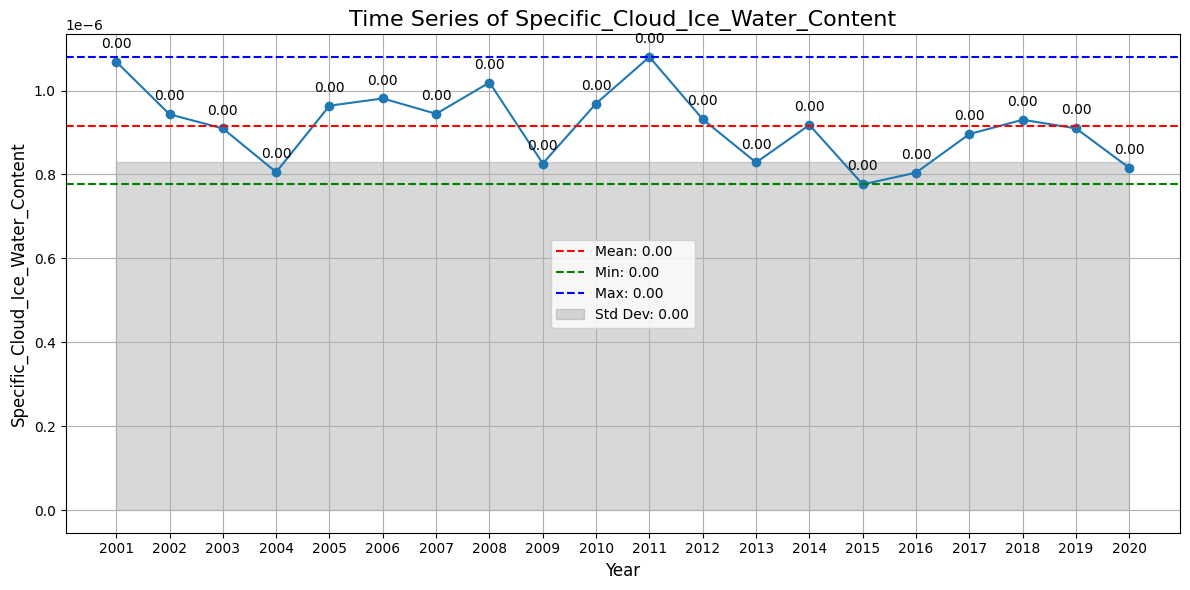

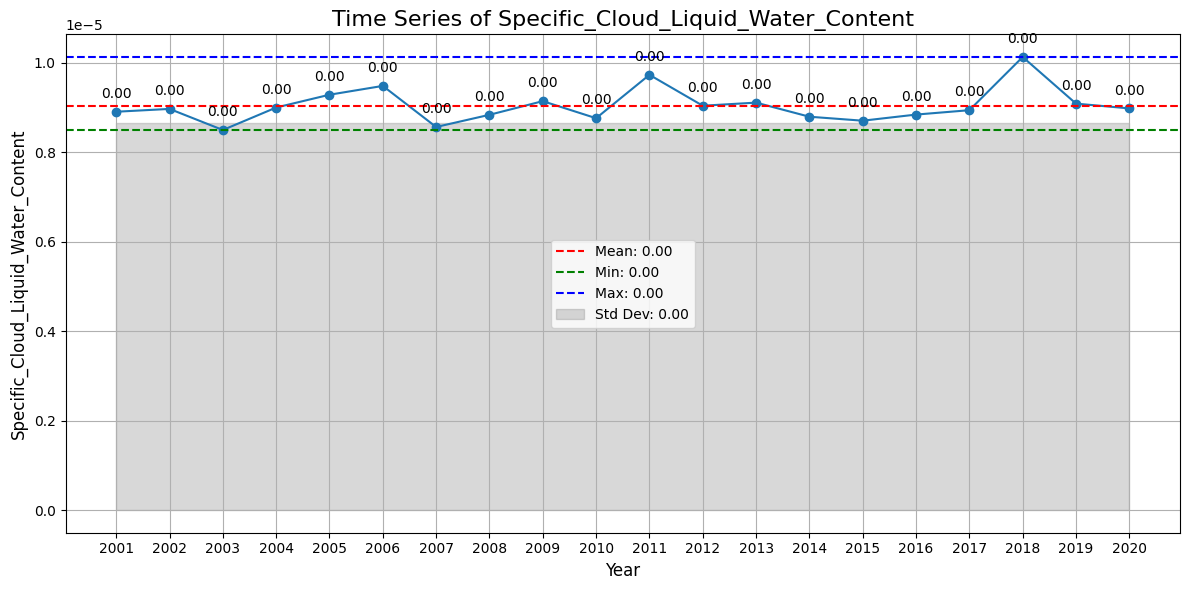

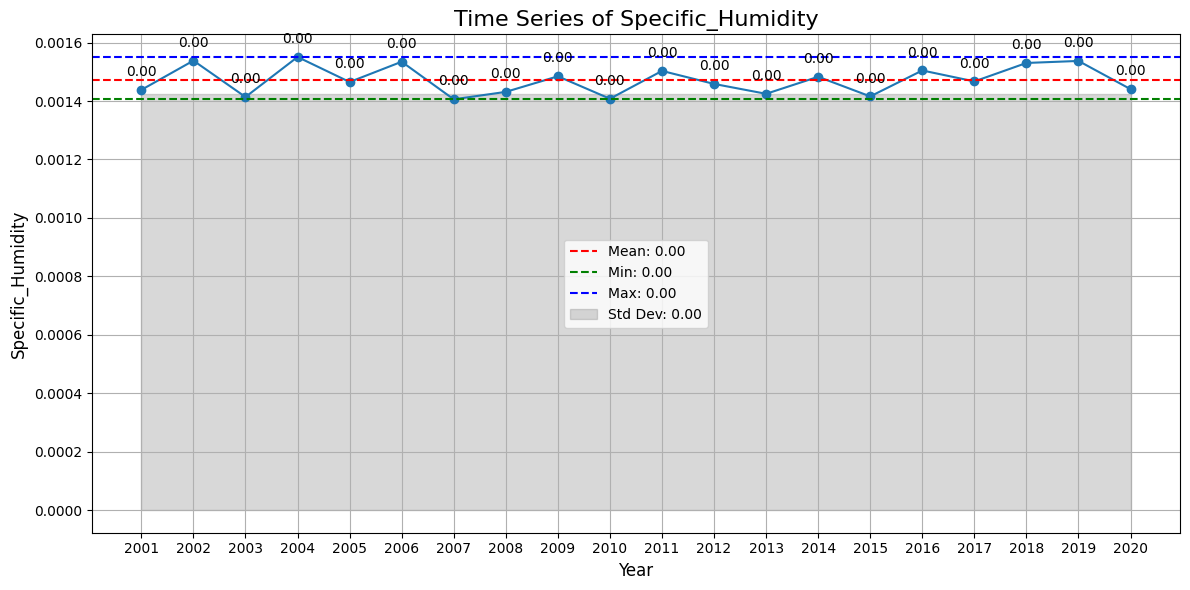

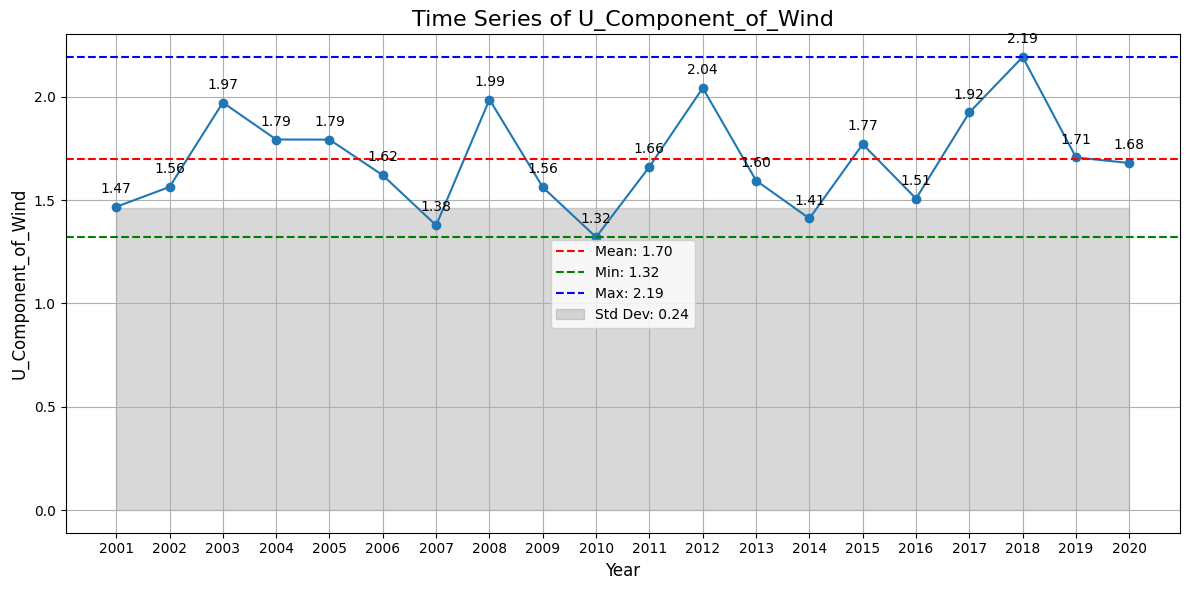

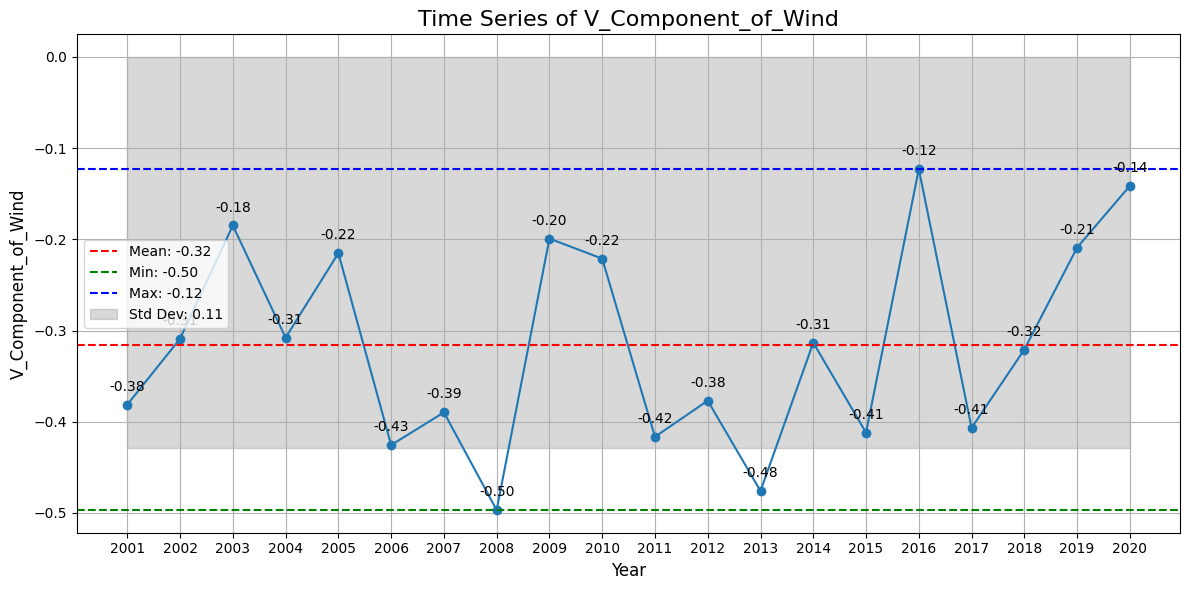

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe from the CSV file
df = pd.read_csv('NGCM_mean_6H_variables.csv')
#remove the index column if present
df = df.drop(df.columns[0], axis=1)

# Convert all columns to numeric, handling errors by coercing them to NaN
for col in df.columns:
    if col != 'Year':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Function to plot with annotations and statistics
def plot_with_stats(data, title, ylabel):
    series = pd.Series(data)
    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()
    plt.figure(figsize=(12, 6))
    plt.plot(years, series.values, marker='o', linestyle='-')
    for i, year in enumerate(years):
        plt.annotate(f'{data[i]:.2f}', (year, data[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axhline(min_val, color='green', linestyle='--', label=f'Min: {min_val:.2f}')
    plt.axhline(max_val, color='blue', linestyle='--', label=f'Max: {max_val:.2f}')
    plt.fill_between(years, mean_val - std_val, color='gray', alpha=0.3, label=f'Std Dev: {std_val:.2f}')
    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.xticks(list(years))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with the dataframe:
years = df['Year'].values.tolist()

# Plotting for each variables
for col in df.columns:
    if col != 'Year':
        plot_with_stats(df[col].values.tolist(), f'Time Series of {col}', col)


Informations sur le DataFrame:
Shape: (20, 10)
Colonnes: ['Year', 'Evaporation', 'Temperature', 'Geopotential', 'Precipitation', 'Specific_Cloud_Ice_Water_Content', 'Specific_Cloud_Liquid_Water_Content', 'Specific_Humidity', 'U_Component_of_Wind', 'V_Component_of_Wind']
Années: 2001 - 2020
Nombre d'années: 20

Valeurs manquantes par colonne:

GÉNÉRATION DES GRAPHIQUES

Traitement de la variable: Evaporation


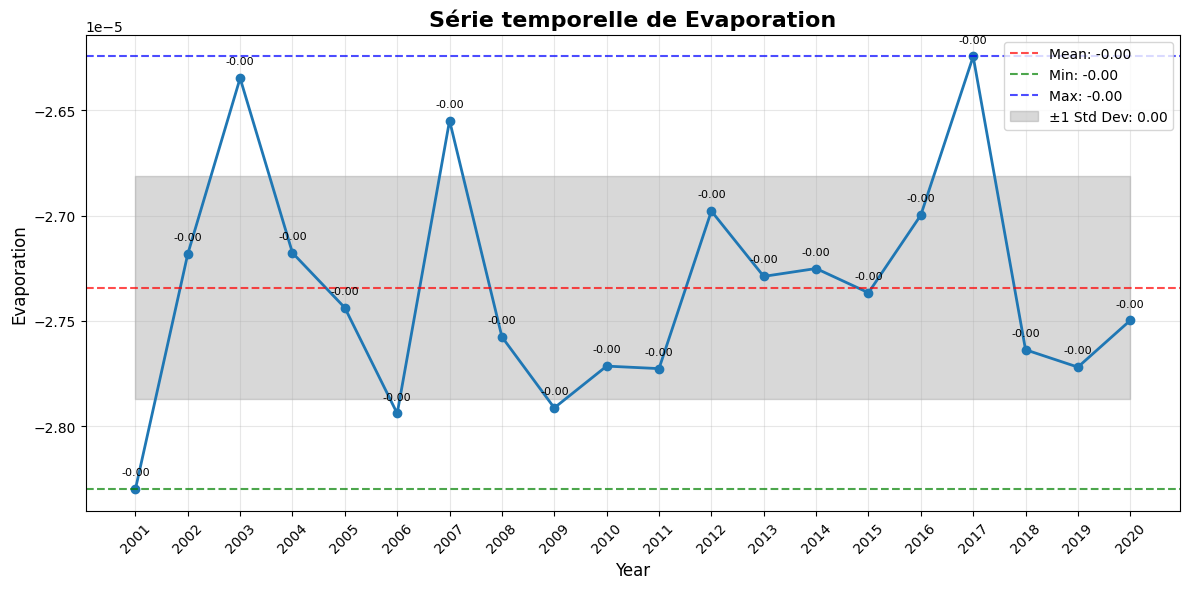


Statistiques pour Série temporelle de Evaporation:
  Moyenne: -0.000
  Écart-type: 0.000
  Min: -0.000
  Max: -0.000
  Nombre de valeurs valides: 20/20

Traitement de la variable: Temperature


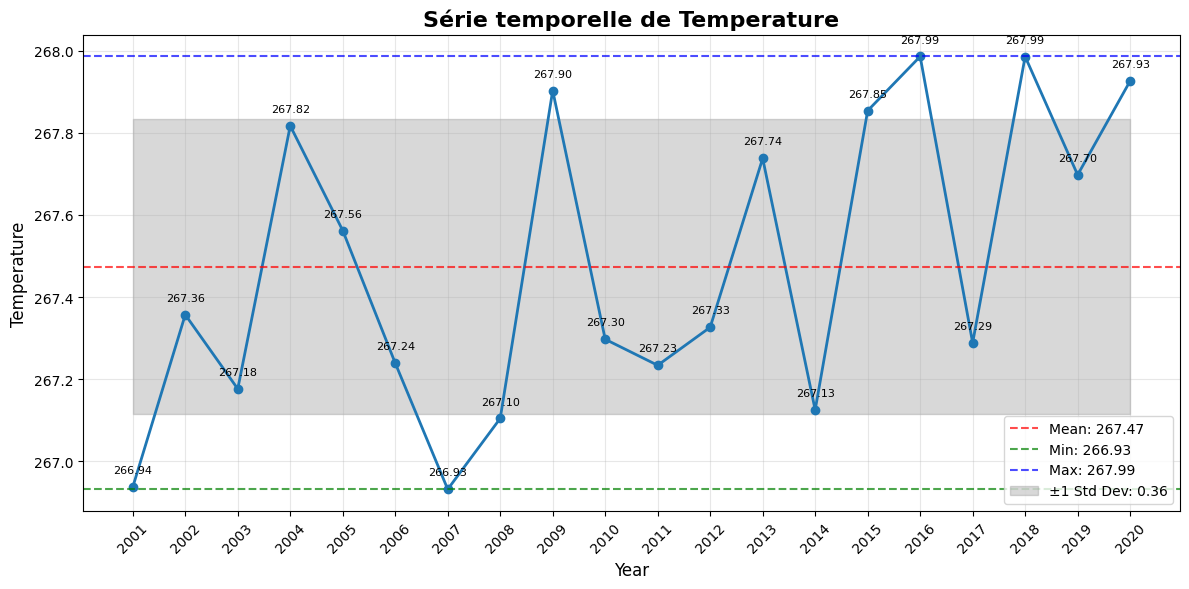


Statistiques pour Série temporelle de Temperature:
  Moyenne: 267.474
  Écart-type: 0.358
  Min: 266.932
  Max: 267.985
  Nombre de valeurs valides: 20/20

Traitement de la variable: Geopotential


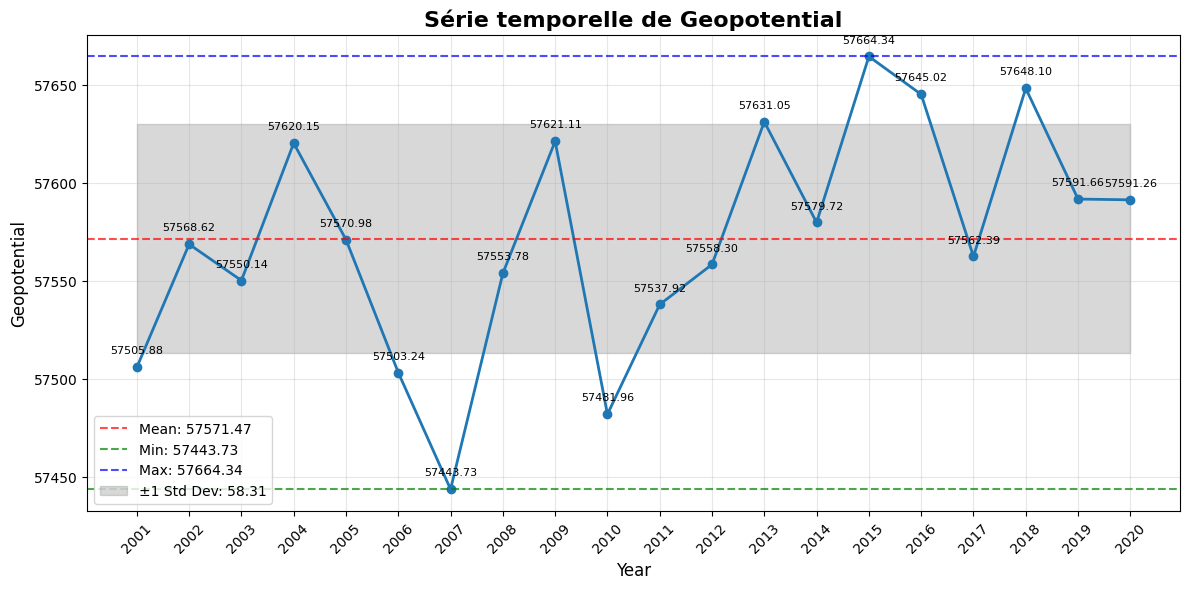


Statistiques pour Série temporelle de Geopotential:
  Moyenne: 57571.468
  Écart-type: 58.310
  Min: 57443.734
  Max: 57664.340
  Nombre de valeurs valides: 20/20

Traitement de la variable: Precipitation


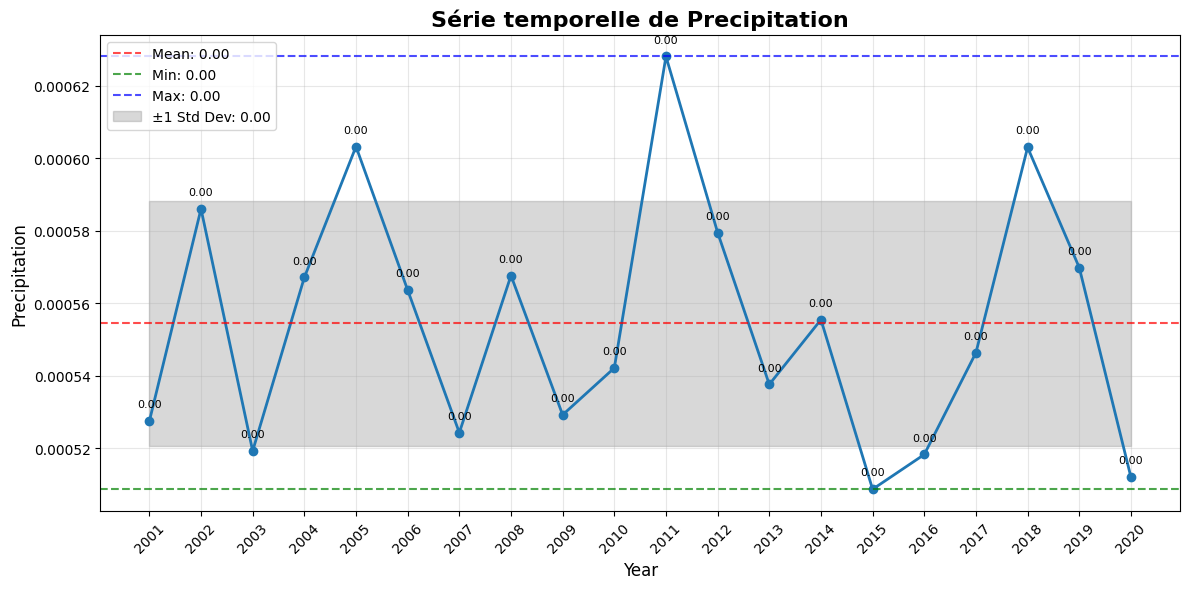


Statistiques pour Série temporelle de Precipitation:
  Moyenne: 0.001
  Écart-type: 0.000
  Min: 0.001
  Max: 0.001
  Nombre de valeurs valides: 20/20

Traitement de la variable: Specific_Cloud_Ice_Water_Content


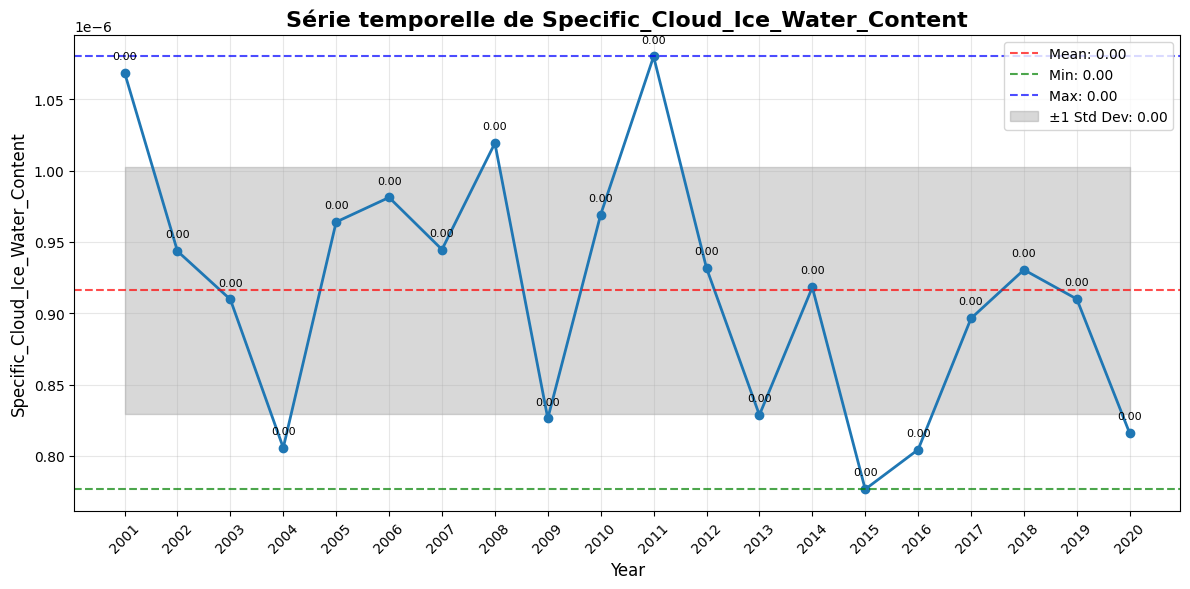


Statistiques pour Série temporelle de Specific_Cloud_Ice_Water_Content:
  Moyenne: 0.000
  Écart-type: 0.000
  Min: 0.000
  Max: 0.000
  Nombre de valeurs valides: 20/20

Traitement de la variable: Specific_Cloud_Liquid_Water_Content


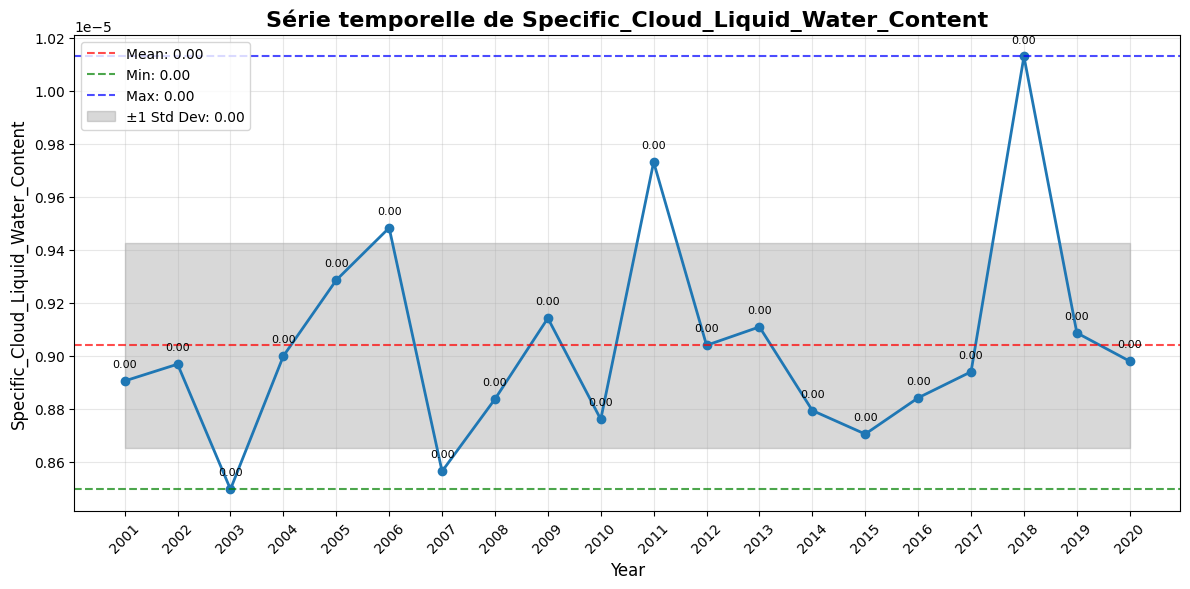


Statistiques pour Série temporelle de Specific_Cloud_Liquid_Water_Content:
  Moyenne: 0.000
  Écart-type: 0.000
  Min: 0.000
  Max: 0.000
  Nombre de valeurs valides: 20/20

Traitement de la variable: Specific_Humidity


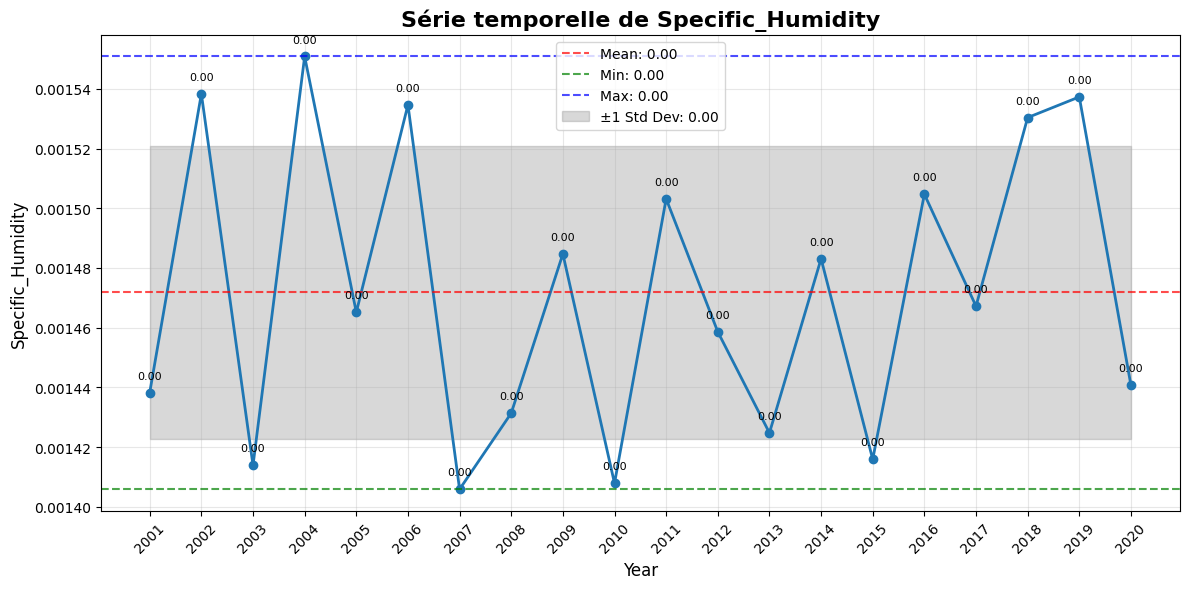


Statistiques pour Série temporelle de Specific_Humidity:
  Moyenne: 0.001
  Écart-type: 0.000
  Min: 0.001
  Max: 0.002
  Nombre de valeurs valides: 20/20

Traitement de la variable: U_Component_of_Wind


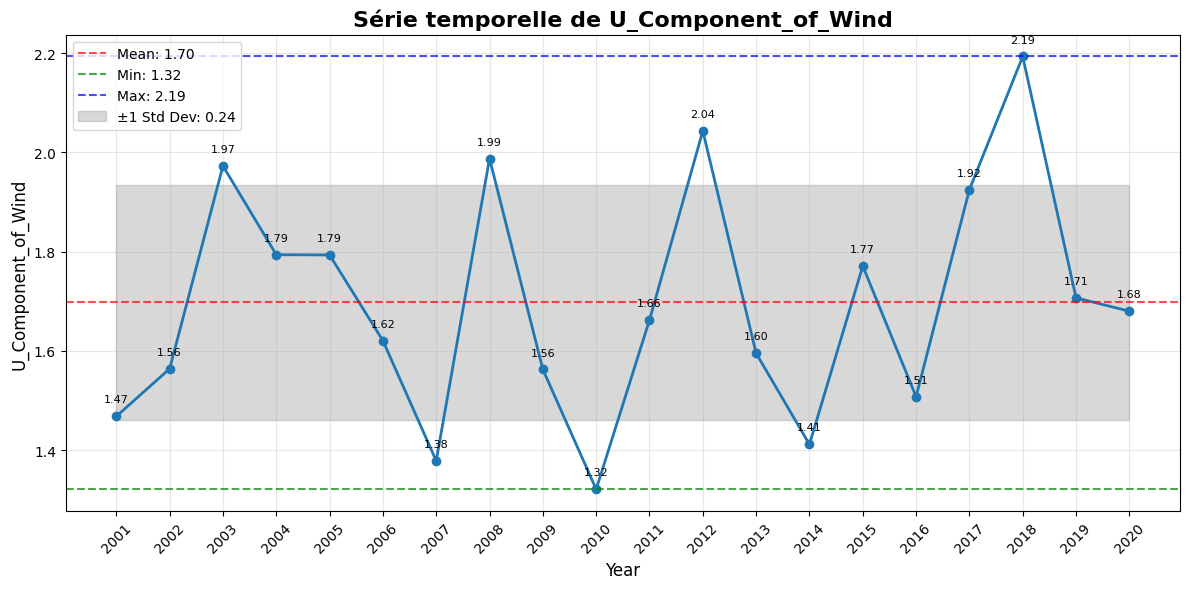


Statistiques pour Série temporelle de U_Component_of_Wind:
  Moyenne: 1.698
  Écart-type: 0.237
  Min: 1.321
  Max: 2.193
  Nombre de valeurs valides: 20/20

Traitement de la variable: V_Component_of_Wind


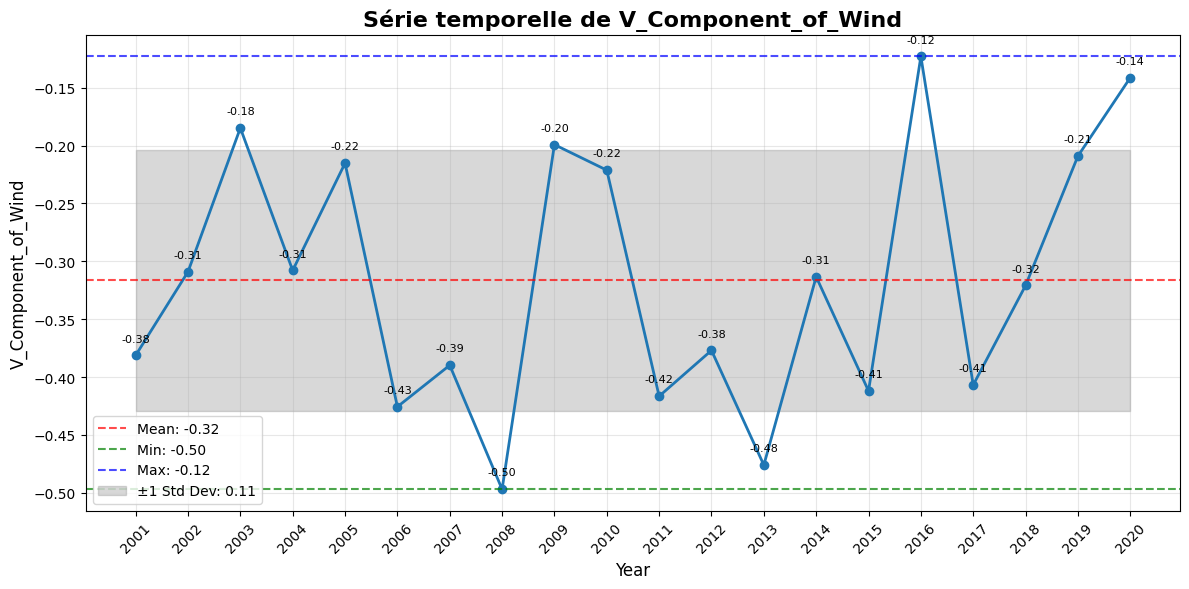


Statistiques pour Série temporelle de V_Component_of_Wind:
  Moyenne: -0.316
  Écart-type: 0.113
  Min: -0.497
  Max: -0.123
  Nombre de valeurs valides: 20/20


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframe from the CSV file
df = pd.read_csv('NGCM_mean_6H_variables.csv')

# Remove the index column if present (more robust way)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
elif df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

# Convert all columns to numeric, handling errors by coercing them to NaN
for col in df.columns:
    if col != 'Year':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Function to plot with annotations and statistics
def plot_with_stats(data, years, title, ylabel):
    # Remove NaN values for statistics calculation
    series = pd.Series(data).dropna()

    if len(series) == 0:
        print(f"Aucune donnée valide pour {title}")
        return

    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()

    plt.figure(figsize=(12, 6))

    # Plot the main line
    plt.plot(years, data, marker='o', linestyle='-', linewidth=2, markersize=6)

    # Add annotations (only if data is not NaN)
    for i, (year, value) in enumerate(zip(years, data)):
        if not pd.isna(value):
            plt.annotate(f'{value:.2f}', (year, value),
                        textcoords="offset points", xytext=(0, 10),
                        ha='center', fontsize=8)

    # Add statistical lines
    plt.axhline(mean_val, color='red', linestyle='--',
                label=f'Mean: {mean_val:.2f}', alpha=0.7)
    plt.axhline(min_val, color='green', linestyle='--',
                label=f'Min: {min_val:.2f}', alpha=0.7)
    plt.axhline(max_val, color='blue', linestyle='--',
                label=f'Max: {max_val:.2f}', alpha=0.7)

    # Add standard deviation band around mean
    plt.fill_between(years, mean_val - std_val, mean_val + std_val,
                     color='gray', alpha=0.3,
                     label=f'±1 Std Dev: {std_val:.2f}')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(list(years), rotation=45 if len(years) > 10 else 0)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nStatistiques pour {title}:")
    print(f"  Moyenne: {mean_val:.3f}")
    print(f"  Écart-type: {std_val:.3f}")
    print(f"  Min: {min_val:.3f}")
    print(f"  Max: {max_val:.3f}")
    print(f"  Nombre de valeurs valides: {len(series)}/{len(data)}")

# Get years
years = df['Year'].values

# Display basic info about the dataframe
print("Informations sur le DataFrame:")
print(f"Shape: {df.shape}")
print(f"Colonnes: {list(df.columns)}")
print(f"Années: {years[0]} - {years[-1]}")
print(f"Nombre d'années: {len(years)}")

# Check for missing values
print(f"\nValeurs manquantes par colonne:")
for col in df.columns:
    missing = df[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} valeurs manquantes")

# Plotting for each variable
print(f"\n{'='*50}")
print("GÉNÉRATION DES GRAPHIQUES")
print(f"{'='*50}")

for col in df.columns:
    if col != 'Year':
        print(f"\nTraitement de la variable: {col}")
        plot_with_stats(df[col].values, years,
                       f'Série temporelle de {col}', col)


GENERATING PLOTS

Processing variable: Evaporation


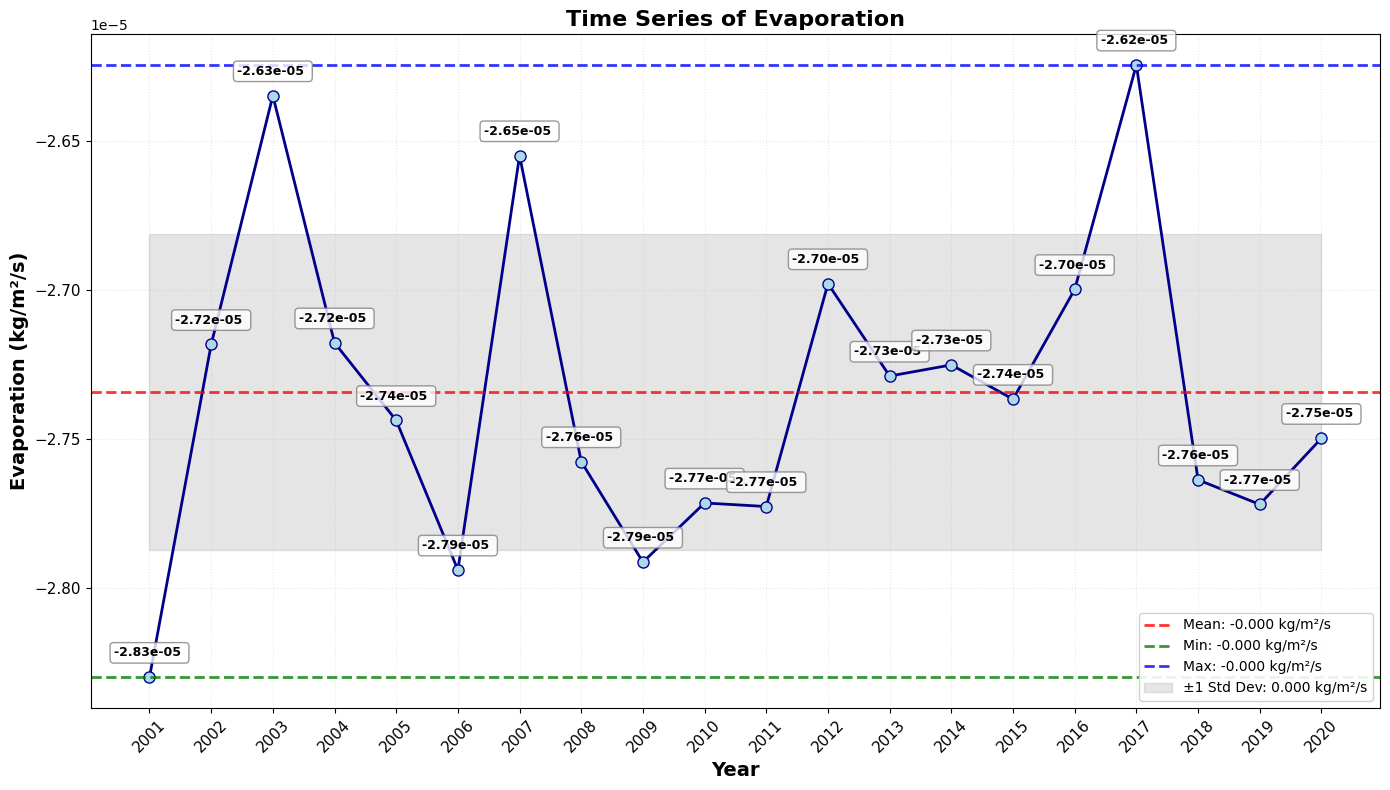


Processing variable: Temperature


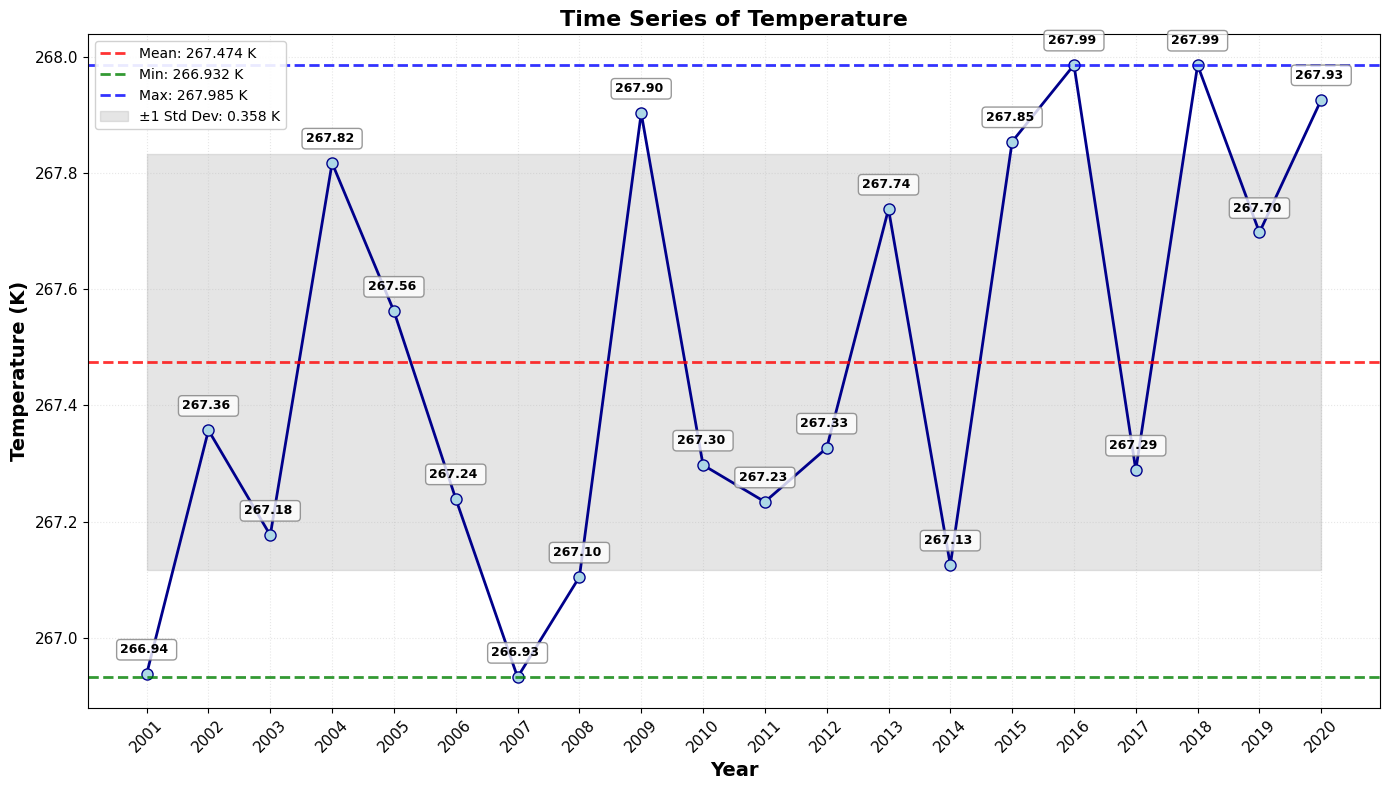


Processing variable: Geopotential


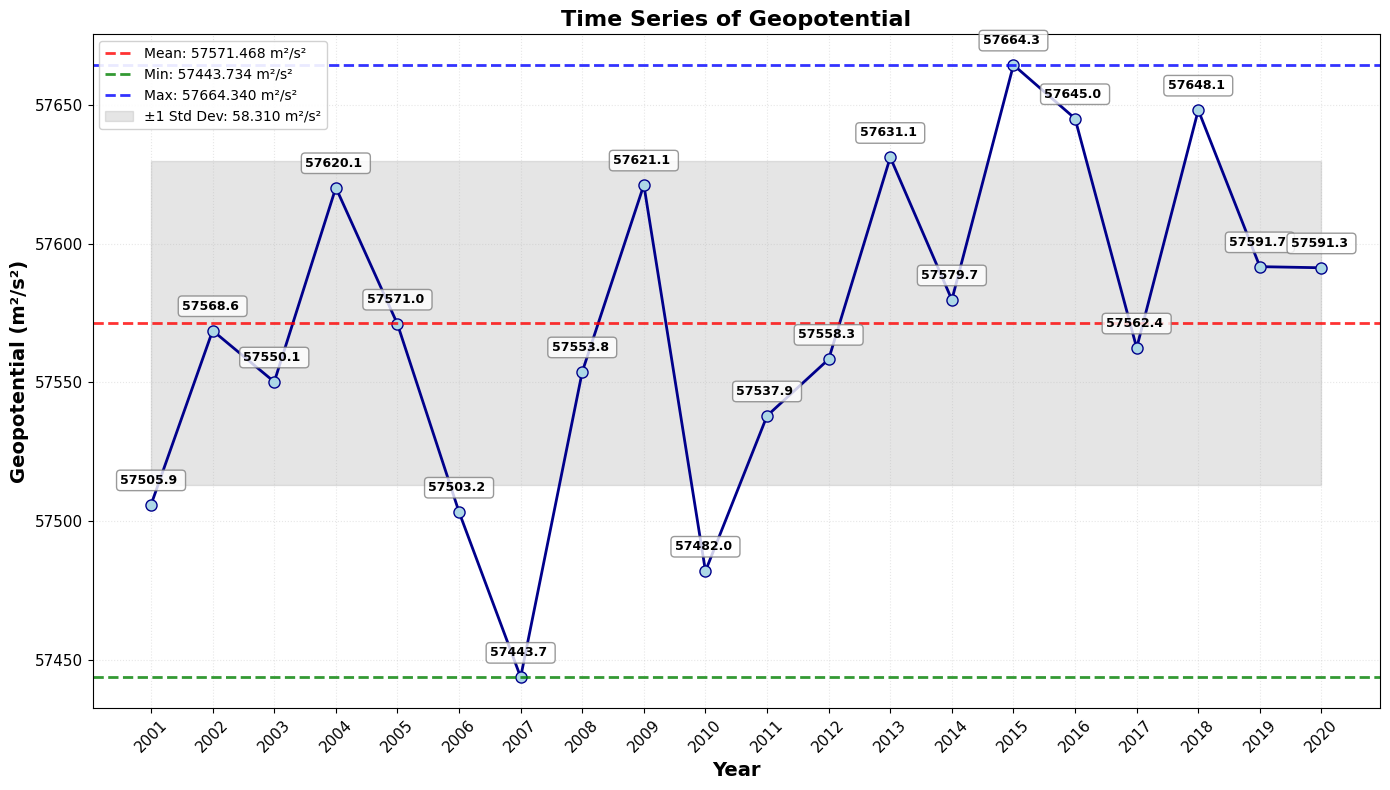


Processing variable: Precipitation


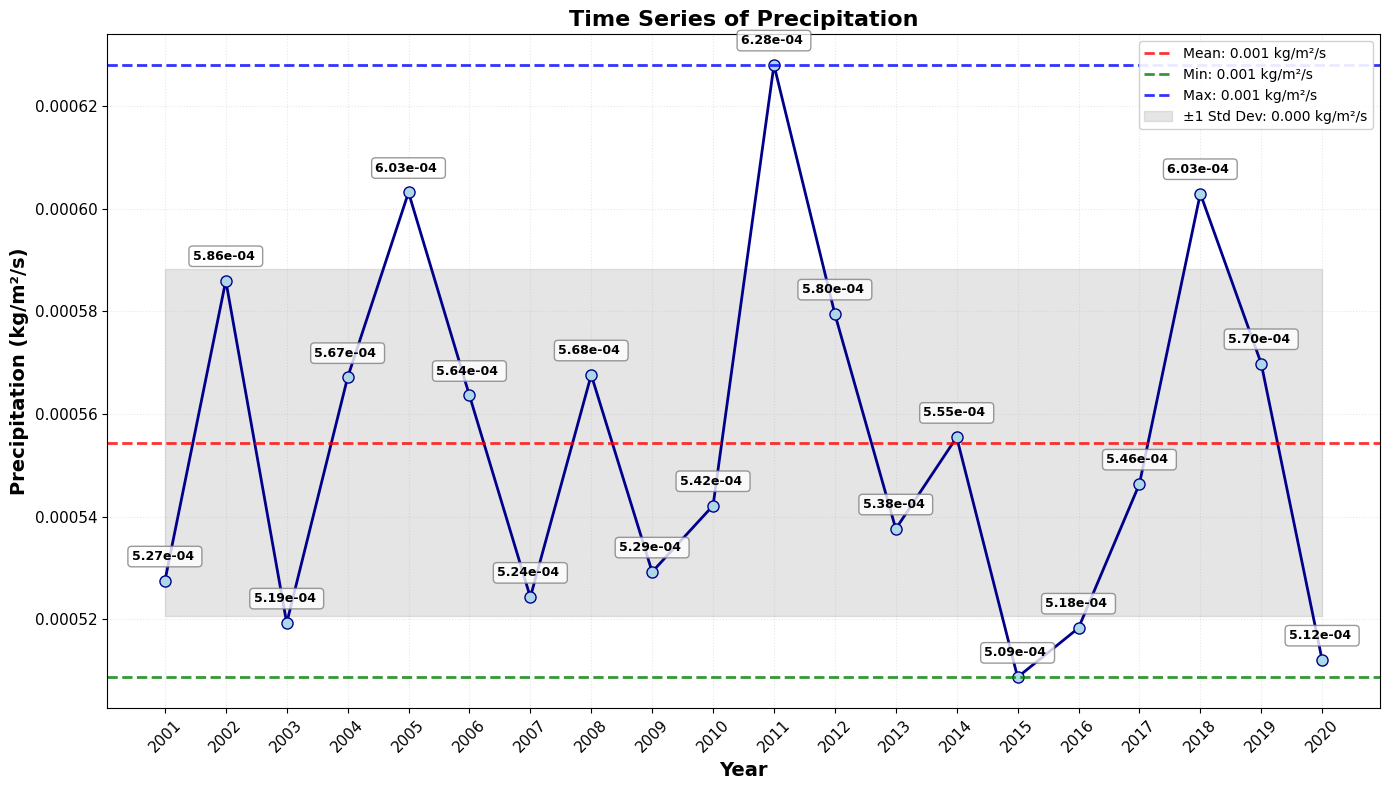


Processing variable: Specific_Cloud_Ice_Water_Content


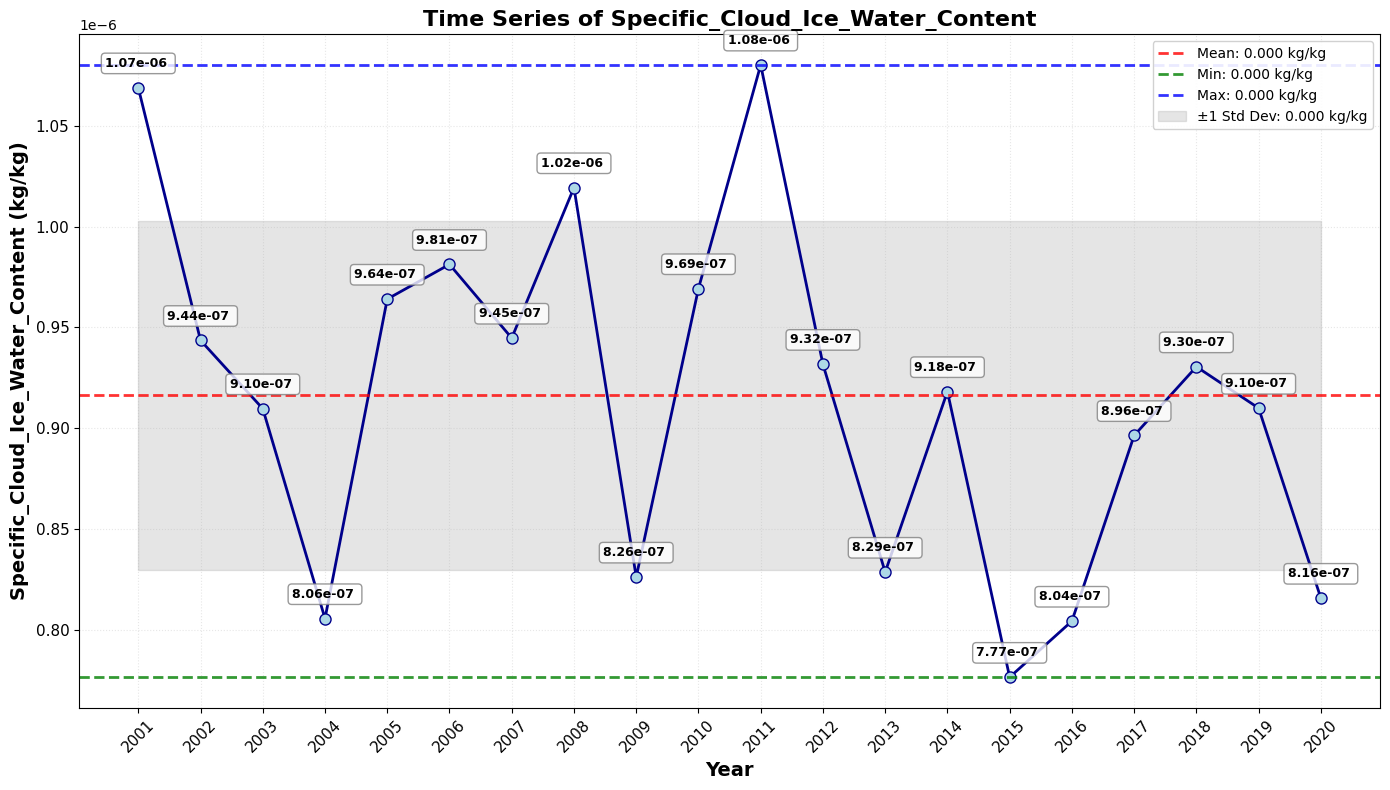


Processing variable: Specific_Cloud_Liquid_Water_Content


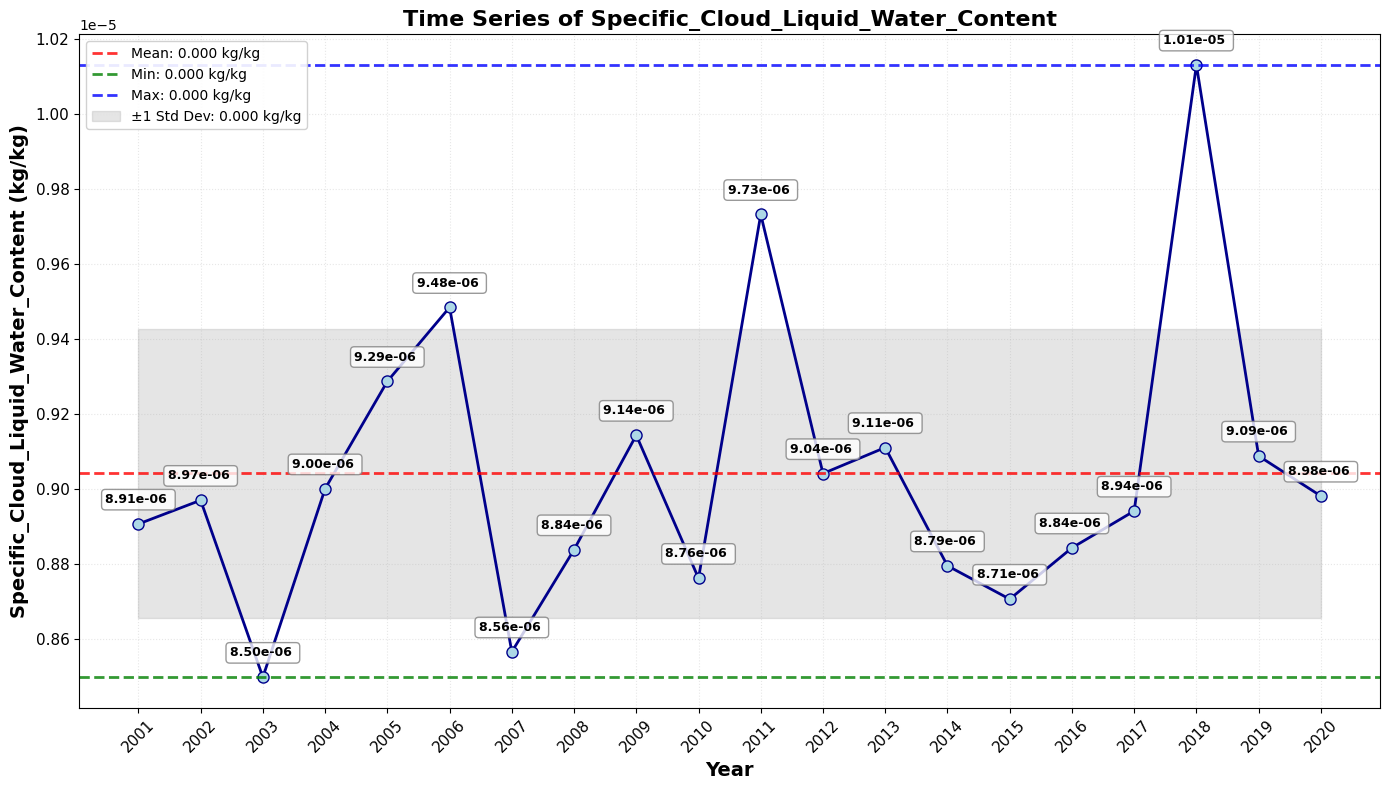


Processing variable: Specific_Humidity


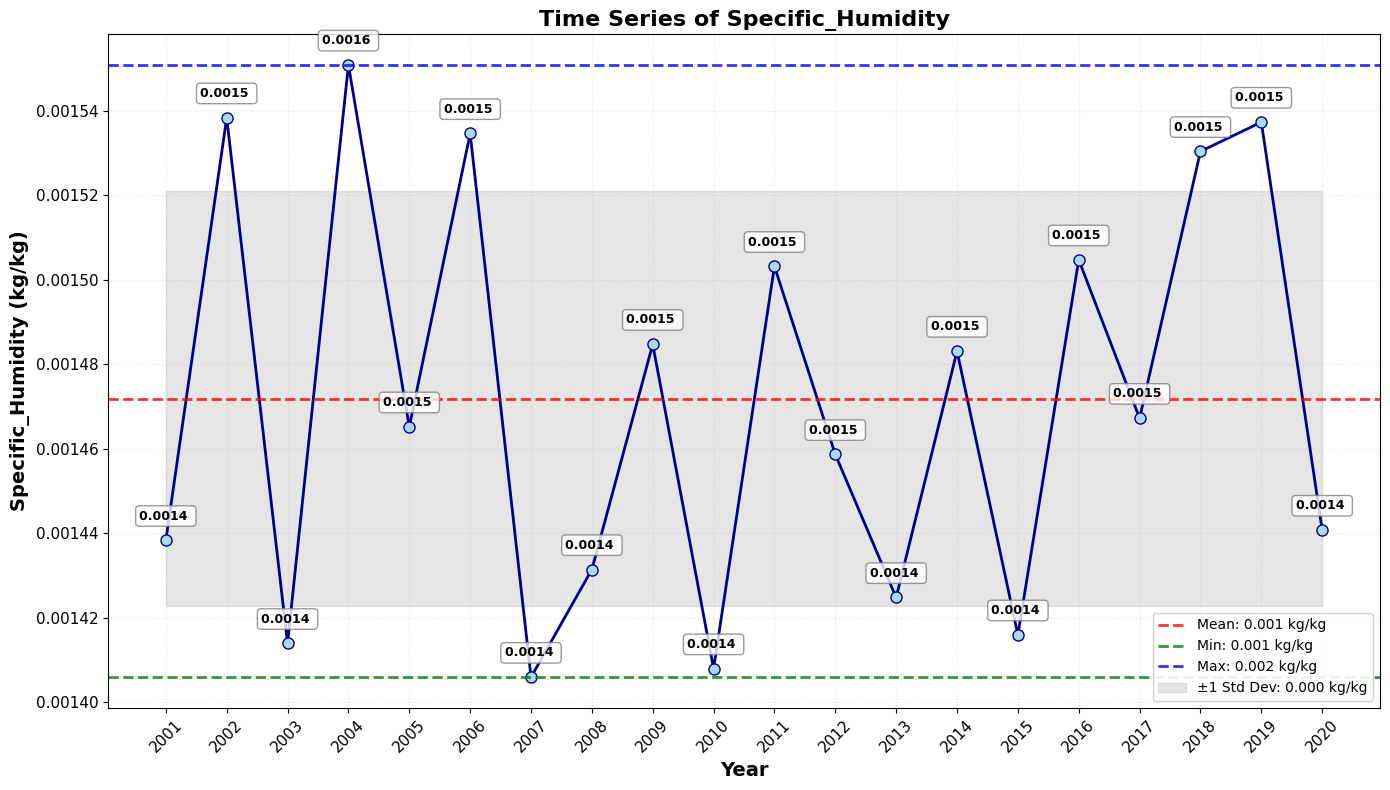


Processing variable: U_Component_of_Wind


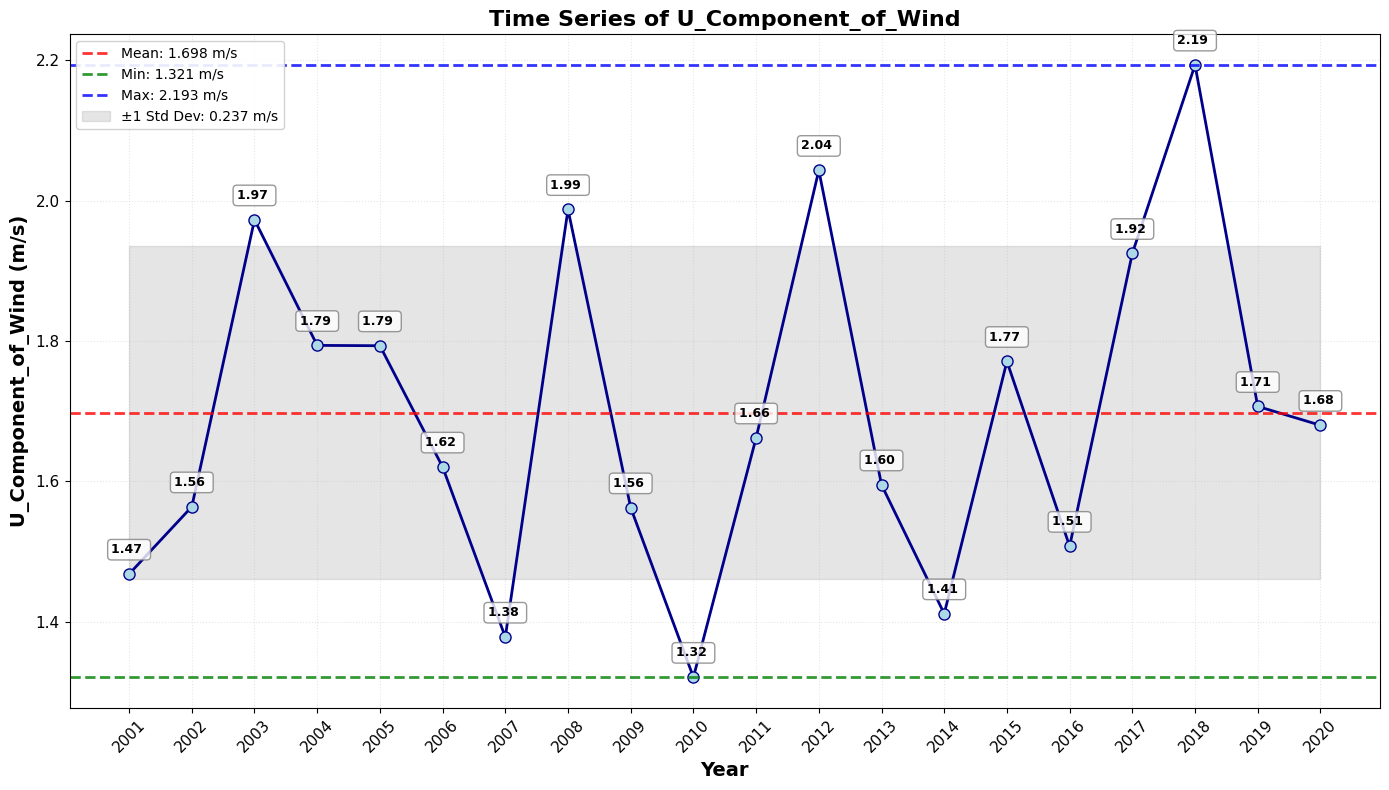


Processing variable: V_Component_of_Wind


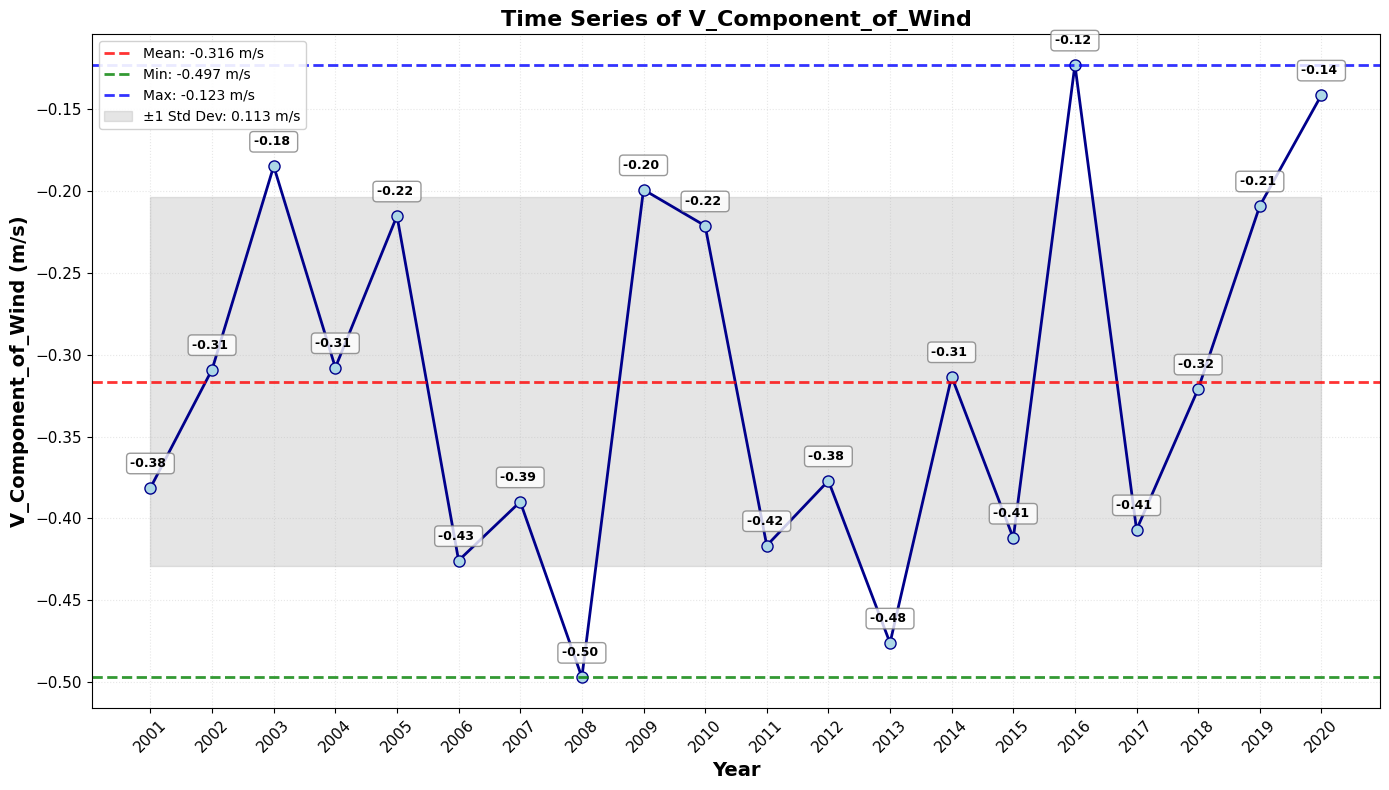

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframe from the CSV file
df = pd.read_csv('NGCM_mean_6H_variables.csv')

# Remove the index column if present (more robust way)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
elif df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

# Convert all columns to numeric, handling errors by coercing them to NaN
for col in df.columns:
    if col != 'Year':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Dictionary with SI units for your specific meteorological variables
UNITS_DICT = {
    'evaporation': 'kg/m²/s',
    'temperature': 'K',
    'geopotential': 'm²/s²',
    'precipitation': 'kg/m²/s',
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s'
}

def get_unit_for_variable(var_name):
    """Determine the SI unit for a variable based on its name"""
    var_lower = var_name.lower().replace(' ', '_')

    # Direct mapping for your specific variables
    if var_lower in UNITS_DICT:
        return UNITS_DICT[var_lower]

    # Fallback for partial matches
    for key, unit in UNITS_DICT.items():
        if key in var_lower or var_lower in key:
            return unit

    # Default SI unit if no match found
    return 'SI units'

# Function to plot with annotations and statistics
def plot_with_stats(data, years, title, ylabel):
    # Remove NaN values for statistics calculation
    series = pd.Series(data).dropna()

    if len(series) == 0:
        # print(f"No valid data for {title}")
        return

    # Get appropriate unit for the variable
    unit = get_unit_for_variable(ylabel)

    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()

    plt.figure(figsize=(14, 8))

    # Plot the main line with larger markers
    plt.plot(years, data, marker='o', linestyle='-', linewidth=2, markersize=8,
             color='darkblue', markerfacecolor='lightblue', markeredgecolor='darkblue')

    # Add annotations with SI units for ALL points (including NaN handling)
    for i, (year, value) in enumerate(zip(years, data)):
        if not pd.isna(value):
            # Format value based on magnitude and type for better readability
            if unit == 'K':  # Temperature - show more precision
                formatted_value = f'{value:.2f}'
            elif unit == 'kg/kg':  # Specific quantities - show scientific notation if very small
                if abs(value) < 0.001:
                    formatted_value = f'{value:.2e}'
                else:
                    formatted_value = f'{value:.4f}'
            elif unit == 'kg/m²/s':  # Fluxes - show scientific notation if very small
                if abs(value) < 0.001:
                    formatted_value = f'{value:.2e}'
                else:
                    formatted_value = f'{value:.4f}'
            elif unit == 'm²/s²':  # Geopotential - usually large values
                formatted_value = f'{value:.1f}'
            elif unit == 'm/s':  # Wind components
                formatted_value = f'{value:.2f}'
            else:
                # General formatting
                if abs(value) >= 1000:
                    formatted_value = f'{value:.1f}'
                elif abs(value) >= 1:
                    formatted_value = f'{value:.2f}'
                elif abs(value) >= 0.001:
                    formatted_value = f'{value:.4f}'
                else:
                    formatted_value = f'{value:.2e}'

            plt.annotate(f'{formatted_value} ', (year, value),
                        textcoords="offset points", xytext=(0, 15),
                        ha='center', fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                alpha=0.8, edgecolor='gray'))

    # Add statistical lines with units
    plt.axhline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.3f} {unit}', alpha=0.8)
    plt.axhline(min_val, color='green', linestyle='--', linewidth=2,
                label=f'Min: {min_val:.3f} {unit}', alpha=0.8)
    plt.axhline(max_val, color='blue', linestyle='--', linewidth=2,
                label=f'Max: {max_val:.3f} {unit}', alpha=0.8)

    # Add standard deviation band around mean
    plt.fill_between(years, mean_val - std_val, mean_val + std_val,
                     color='gray', alpha=0.2,
                     label=f'±1 Std Dev: {std_val:.3f} {unit}')

    plt.title(f'{title}', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=14, fontweight='bold')
    plt.ylabel(f'{ylabel} ({unit})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle=':')
    plt.xticks(list(years), rotation=45 if len(years) > 10 else 0, fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend(loc='best', fontsize=10, framealpha=0.9)
    plt.tight_layout()
    plt.show()

    # Print detailed statistics with units
    # print(f"\nDetailed Statistics for {title}:")
    # print(f"  Mean: {mean_val:.4f} {unit}")
    # print(f"  Std Dev: {std_val:.4f} {unit}")
    # print(f"  Min: {min_val:.4f} {unit}")
    # print(f"  Max: {max_val:.4f} {unit}")
    # print(f"  Range: {max_val - min_val:.4f} {unit}")
    # print(f"  Valid values: {len(series)}/{len(data)}")
    # print(f"  Unit detected: {unit}")

    # Print all individual values with years and units
    # print(f"\nAll individual values:")
    # for year, value in zip(years, data):
    #     if not pd.isna(value):
    #         print(f"  {year}: {value:.4f} {unit}")
    #     else:
    #         print(f"  {year}: No data")

# Get years
years = df['Year'].values

# Display basic info about the dataframe
# print("DataFrame Information:")
# print(f"Shape: {df.shape}")
# print(f"Columns: {list(df.columns)}")
# print(f"Years: {years[0]} - {years[-1]}")
# print(f"Number of years: {len(years)}")

# Check for missing values
# print(f"\nMissing values by column:")
for col in df.columns:
    missing = df[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing values")

# Plotting for each variable
print(f"\n{'='*50}")
print("GENERATING PLOTS")
print(f"{'='*50}")

for col in df.columns:
    if col != 'Year':
        print(f"\nProcessing variable: {col}")
        plot_with_stats(df[col].values, years,
                       f'Time Series of {col}', col)

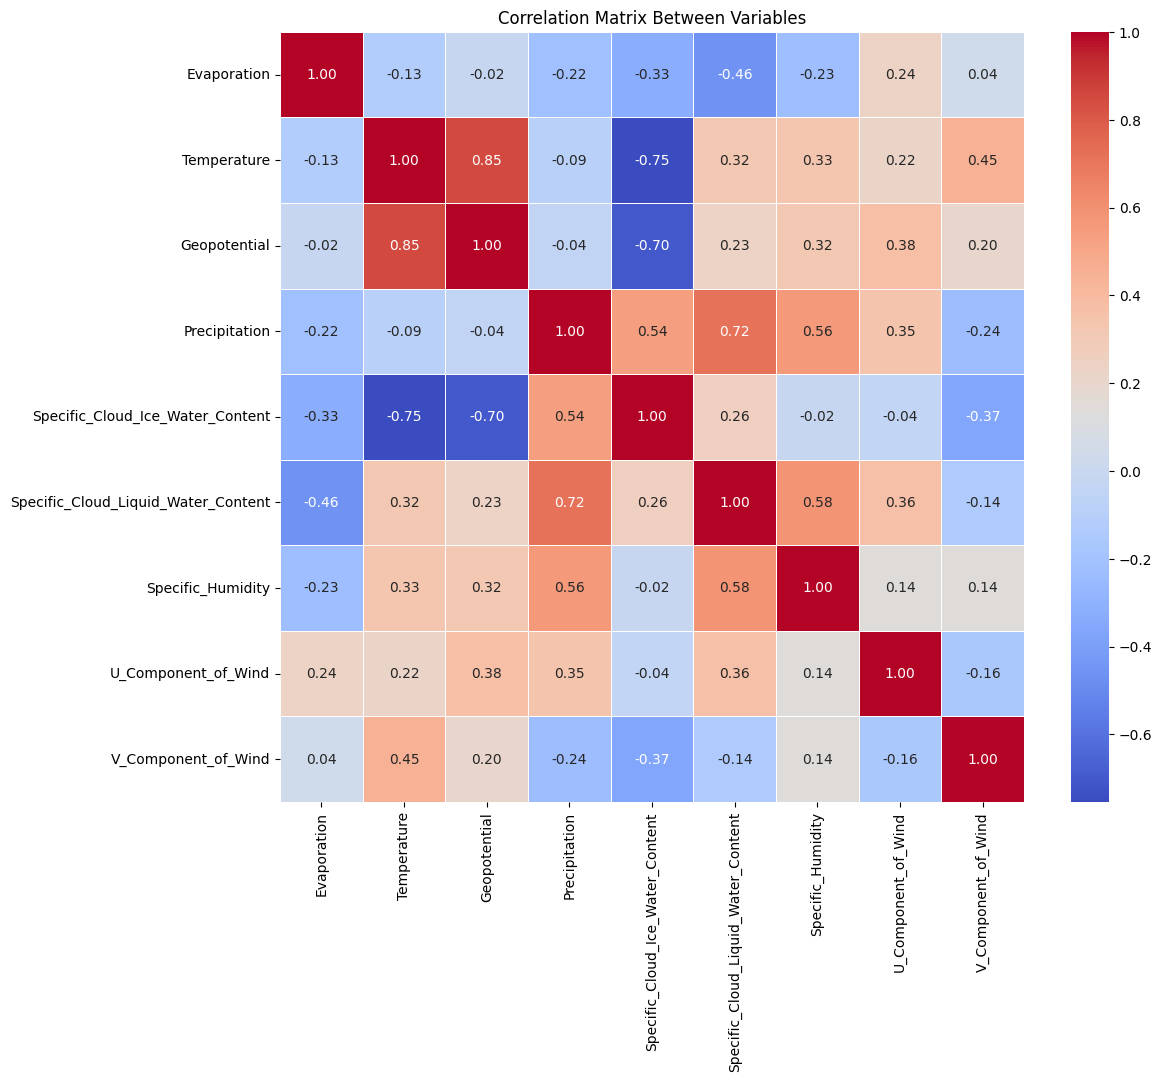

In [ ]:
df = df.drop(columns=['Year'])
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Between Variables")
plt.show()


In [ ]:
precipitation_cumulative_mean_group_year[2001].isel(date=-1).mean(dim=('longitude','latitude')).values[0]


array([0.78546256], dtype=float32)

In [ ]:
import pandas as pd
import tqdm  # Import tqdm for the progress bar

# Assuming precipitation_cumulative_mean_group_year is already defined

precipitation_values = []
years = range(2001, 2021)  # Years from 2001 to 2020

for year in tqdm.tqdm(years, desc="Processing Years"):
    # Calculate the mean precipitation for the last day of each year
    try:
        precipitation_mean = precipitation_cumulative_mean_group_year[year].isel(date=-1).mean(dim=('longitude', 'latitude')).values[0]
        precipitation_values.append(precipitation_mean)
    except KeyError as e:
        print(f"Year {year} not found in the data. Skipping.")
        precipitation_values.append(None)  # Append None if the year is not found

# Create a DataFrame from the list of precipitation values
precipitation_df = pd.DataFrame({'Year': years, 'Precipitation': precipitation_values})

precipitation_df


Processing Years: 100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


Year Precipitation
0   2001  [0.78546256]
1   2002   [1.5116063]
2   2003   [2.3950338]
3   2004   [3.2022047]
4   2005    [4.018671]
5   2006   [4.7879252]
6   2007   [5.6288657]
7   2008   [6.4681864]
8   2009    [7.285275]
9   2010    [8.124825]
10  2011     [8.98412]
11  2012    [9.887905]
12  2013   [10.704088]
13  2014   [11.526203]
14  2015   [12.363941]
15  2016   [13.160943]
16  2017   [13.982449]
17  2018   [14.695099]
18  2019   [15.675676]
19  2020   [16.499899]

In [ ]:
from google.colab import files
precipitation_df.to_csv('precipitation.csv', encoding = 'utf-8-sig')
files.download('precipitation.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
evaporation_group_year[2001].mean(dim=('date','longitude','latitude')).values[0]